## The purpose of this notebook is to investigate the efficacy of meta tags given only the tags on the homepage

We will use the newsguard dataset for this

## NEXT STEPS:

See how many pages need to be scraped before the classifier performance matches that of the classifier working with up to 100 sub-pages

full_df.pkl saved in this directory currently contains tokens for top level meta

In [24]:
from pathlib import Path
import pickle
import os
import pandas as pd

# First, let's see which .txt file the homepage corresponds to. We will use the link_dict for this, present in the dataframes
with open(r'C:\Users\ewais\Documents\GitHub\misinfo_detection\urls\500_fake_df.pkl', 'rb') as f:
    fake_df = pickle.load(f)
f.close() 
with open(r'C:\Users\ewais\Documents\GitHub\misinfo_detection\urls\500_real_df.pkl', 'rb') as f:
    real_df = pickle.load(f)
f.close()

def find_indices_of_home_page(df):
    '''
    Takes dataframe and appends a column corresponding to the index in link_dict containing the homepage
    Uses the fact that the homepage usually corresponds to the domain with the smallest length
    '''
    homepages = []
    for _, row in df.iterrows():
        min_len = 10000
        smallest = 0
        for k, v in row.link_dict.items():
            length = len(v)
            if length < min_len:
                min_len = length
                smallest = k
        homepages.append(smallest)
    df['homepage_index'] = homepages
    return df

real_df = find_indices_of_home_page(real_df)
fake_df = find_indices_of_home_page(fake_df)

fake_df.head()

,site,num_links,link_dict,homepage_index
index,,,,
0,http://whatfinger.com,170,"{0: 'https://www.whatfinger.com/', 1: 'https:/...",0
1,http://missouridownload.com,5,"{0: 'https://missouridownload.com/', 1: 'https...",0
2,http://truepundit.com,89,"{0: 'https://truepundit.com/#', 1: 'https://tr...",1
3,http://teaparty.org,135,"{0: 'https://www.teaparty.org/', 1: 'https://w...",0
4,http://georgiastarnews.com,732,{0: 'https://georgiastarnews.com/#home-content...,1


In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm

def clean_text(text):
    '''
    cleans text of punctuation, strange characters, and numbers
    '''
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    punc_list = '!"#$%&()*+, -./:;<=>?@[\]^_{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    return text.lower()

def tokenize_dataframe(df, source_col, target_col):
    '''
    Takes df[col] and tokenizes the string into a list of tokens
    '''
    tokenized = []
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    for _, row in tqdm(df.iterrows()):
        text = row[source_col]
        text = clean_text(text)
        tokens = word_tokenize(text)
        lemstem = []
        for word in tokens:
            lemstem.append(porter.stem(lemmatizer.lemmatize(word)))
        final = [w for w in lemstem if not w in stop_words]

        tokenized.append(final)

    df[target_col] = tokenized

    return df

df = tokenize_dataframe(df, 'meta text', 'meta tokenized')

In [25]:
from pathlib import Path
import pickle
import os
import pandas as pd

# Loop through the parsed text, fill in dataframe along the way
real_dir = Path.cwd() / 'meta_tags_parsed' / 'real'
fake_dir = Path.cwd() / 'meta_tags_parsed' / 'fake'

with open(r'C:\Users\ewais\Documents\GitHub\misinfo_detection\ensemble_analysis\full_df.pkl', 'rb') as f:
    full_df = pickle.load(f)
f.close()

full_df.head()

,global_index,subindex,site,label,y,text,tokenized,meta text,meta tokenized,domain,...,percent_fake_incoming,percent_fake_outgoing,incoming_to_outgoing_ratio,color,vectorized_links,reduced_content,reduced_meta,meta_tfidf,content_tfidf,combined_features
0,0,0,http://9to5mac.com,real,0,"In a memo that was leaked to the Verge , Cook ...","[memo, wa, leak, verg, cook, say, appl, “, eve...","News and reviews for Apple products, apps, an...","[news, review, appl, product, app, rumor, prov...",.9to5mac.com,...,0.80,0.0,0.555556,blue,"[0.8, 0.0, 0.5555555555555556]","[menu, privaci, click, menu, privaci, web, men...","[archiv, archiv, archiv, team, team, archiv, a...","[0.007999945484681643, 0.0, 0.0, 0.0, 0.0, 0.0...","[6.015106742123853e-05, 4.242046252967632e-05,...","[6.015106742123853e-05, 4.242046252967632e-05,..."
1,1,1,http://wfae.org,real,0,Charlotte Talks Local News Roundup: Housing...,"[charlott, talk, local, news, roundup, hous, f...","Charlotte Podcasts,Charlotte music,Charlotte ...","[charlott, podcast, charlott, music, charlott,...",.wfae.org,...,0.25,0.0,0.666667,blue,"[0.25, 0.0, 0.6666666666666666]","[mask, privaci, privaci, privaci, art, obituar...","[sport, counti, counti, counti, counti, counti...","[0.0, 0.0039710173979345025, 0.007729236373152...","[0.011508904233263641, 0.002842170989488313, 0...","[0.011508904233263641, 0.002842170989488313, 0..."
2,2,2,http://climatefeedback.org,real,0,The workshop will then move to more concrete e...,"[workshop, move, concret, exampl, initi, tackl...",Scientific Reference to Reliable Information ...,"[scientif, refer, reliabl, inform, climat, cha...",.climatefeedback.org,...,0.00,0.0,0.125000,blue,"[0.0, 0.0, 0.125]","[art, trump, dr, trump, dr, net, net, net, har...","[climat, climat, scienc, scienc, climat, clima...","[0.0, 0.0023826104387607017, 0.001545847274630...","[0.00012030213484247706, 0.0003605739315022487...","[0.00012030213484247706, 0.0003605739315022487..."
3,3,3,http://wdbj7.com,real,0,Power Life by Tony Horton All Adult...,"[power, life, toni, horton, adult, due, larg, ...","wdbj, virginia local news, virginia weather, ...","[wdbj, virginia, local, news, virginia, weathe...",.wdbj7.com,...,0.25,0.0,2.000000,blue,"[0.25, 0.0, 2.0]","[privaci, web, mask, funer, privaci, funer, pr...","[weather, sport, weather, sport, weather, spor...","[0.0, 0.003176813918347602, 0.0030916945492609...","[0.0004611581835628288, 0.0008484092505935265,...","[0.0004611581835628288, 0.0008484092505935265,..."
4,4,4,http://keyc.com,real,0,Good To Know This Recommended by ...,"[good, know, thi, recommend, recommend, high, ...","keyc, keyc 12 keyc news 12, keyc tv, keyc new...","[keyc, keyc, keyc, news, keyc, tv, keyc, news,...",.keyc.com,...,1.00,0.0,0.500000,blue,"[1.0, 0.0, 0.5]","[mask, mask, mask, privaci, privaci, privaci, ...","[weather, sport, weather, sport, weather, spor...","[0.0, 0.004765220877521403, 0.0015458472746304...","[0.00020050355807079513, 0.0007847785567990119...","[0.00020050355807079513, 0.0007847785567990119..."


In [37]:
content_list = []
num_missing = 0
for idx, row in full_df.iterrows():
    if row.label == 'real':
        link_df = real_df
    else:
        link_df = fake_df

    homepage_text_file = Path.cwd() / 'meta_tags_parsed' / row.label / str(row['subindex']) / (str(link_df.loc[row.subindex, 'homepage_index'])+'.txt') 
    
    content = ''
    try:
        with open(homepage_text_file, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()
    except FileNotFoundError as err:
        num_missing += 1
        files = os.listdir(homepage_text_file.parent)
        try:
            default_file = homepage_text_file.parent / files[0]
        except:
            content += 'none'
        with open(default_file, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()


    page_content = ' '.join(lines)

    content = content + page_content
    if content == '':
        print(f'no content at {homepage_text_file}')
        content += 'none'
    content_list.append(content)

print('There are {} missing files'.format(num_missing))
full_df['top_level_meta_text'] = content_list

no content at c:\Users\ewais\Documents\GitHub\misinfo_detection\meta tag analysis\meta_tags_parsed\fake\0\0.txt
There are 194 missing files


In [39]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm

def clean_text(text):
    '''
    cleans text of punctuation, strange characters, and numbers
    '''
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    punc_list = '!"#$%&()*+, -./:;<=>?@[\]^_{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    return text.lower()

def tokenize_dataframe(df, source_col, target_col):
    '''
    Takes df[col] and tokenizes the string into a list of tokens
    '''
    tokenized = []
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    for _, row in tqdm(df.iterrows()):
        text = row[source_col]
        text = clean_text(text)
        tokens = word_tokenize(text)
        lemstem = []
        for word in tokens:
            lemstem.append(porter.stem(lemmatizer.lemmatize(word)))
        final = [w for w in lemstem if not w in stop_words]

        tokenized.append(final)

    df[target_col] = tokenized

    return df

full_df = tokenize_dataframe(full_df, 'top_level_meta_text', 'top_level_meta_tokenized')

999it [00:04, 209.70it/s]


In [42]:
# Save dataframe
with open('full_df.pkl', 'wb') as f:
    pickle.dump(full_df, f)
f.close()

In [ ]:
# Load
with open('df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()

  4%|▍         | 4/100 [00:00<00:02, 39.59it/s]

ONE MODEL EXAMPLE:


logistic regression classifier
-------------
accuracy: 82.0 %
baseline: 50.8 %

f1:         0.8207
precision:  0.8306
recall:     0.8110


size of vocab: 129

   top "real" words top "fake" words
0              food          conserv
1            commun         american
2               get            truth
3           central            polit
4            scienc            natur
5             video           medium
6            valley            peopl
7              citi          america
8           traffic              top
9            counti            right
10            cover             free
11            event           altern
12         obituari           articl
13            break            world
14             news           around
15             busi           health
16              job           global
17            local             mind
18          weather            state
19            sport           websit


100%|██████████| 100/100 [00:02<00:00, 39.59it/s]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.758503  0.783720     0.808937
1         f1     0.750858  0.777802     0.804745
2  precision     0.752835  0.789345     0.825855
3     recall     0.729065  0.768418     0.807771


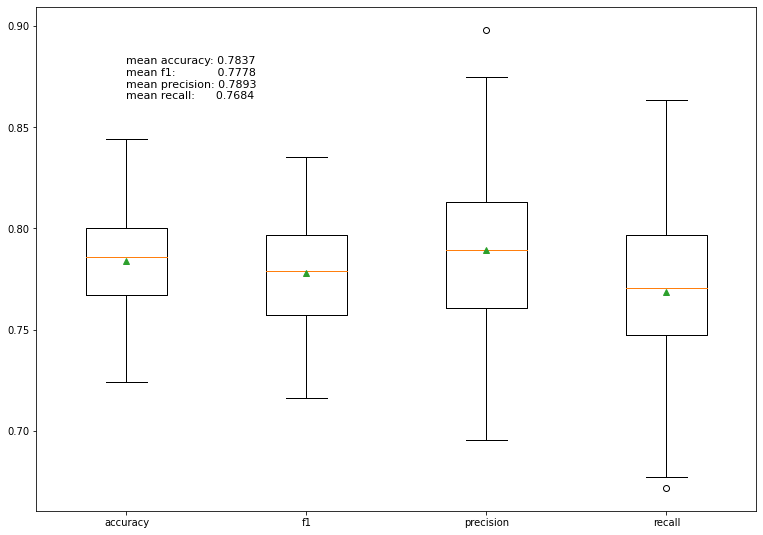

In [43]:
import sys
sys.path.insert(1,r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\analyses v2')
from analysis_functions import *

# Analyze
print('ONE MODEL EXAMPLE:')
model, _, X_test, _, y_test, _, vocab = train_logistic_regression(full_df, 'top_level_meta_tokenized', meta_name=False)
accuracy, f1, precision, recall = evaluate_logistic_regression(model, X_test, y_test, vocab, PRINT=True)

_ = confidence_interval_logistic_regression(100, full_df, col='top_level_meta_tokenized')

## Investigate top logits


In [45]:
# with open('df_tokenized.pkl', 'rb') as f:
    # df = pickle.load(f)
# f.close()

logit_weights, logit_signs, logit_tokens = logit_explained_variance(full_df, 'top_level_meta_tokenized', num_iterations=100)

# with open('logit_weights.pkl', 'wb') as f:
    # pickle.dump(logit_weights,f)
# f.close()

# with open('logit_signs.pkl', 'wb') as f:
    # pickle.dump(logit_signs, f)
# f.close()

# with open('logit_tokens.pkl', 'wb') as f:
    # pickle.dump(logit_tokens, f)
# f.close()

100%|██████████| 100/100 [00:02<00:00, 41.37it/s]


In [46]:
for i in range(1,100):
    print('{} : {}'.format(logit_tokens[i], logit_weights[i]))

sport : -0.08393045670322799
weather : -0.06411842342582366
local : -0.04135729017216062
conserv : 0.0407485746725285
polit : 0.036170037328814644
natur : 0.03398992714754196
american : 0.03395289022874062
break : -0.033928576809163974
citi : -0.03190743560529568
truth : 0.03165723575451915
medium : 0.031271756750973566
counti : -0.031103504103470132
health : 0.030312658428448432
america : 0.030158327276576725
job : -0.028679497126307657
obituari : -0.02833569506643019
news : -0.028266215755149794
around : 0.02449403727512033
scienc : -0.024434382623647163
altern : 0.02419989261490724
right : 0.02404062430198341
com : -0.023990277436425317
peopl : 0.023657974555344685
cover : -0.022659845194963793
event : -0.022197601828766754
valley : -0.02213957447009053
journal : -0.02211868418820078
healthi : 0.021973554362975843
traffic : -0.021911396583636784
free : 0.021728358281828904
new : -0.020274027020406288
global : 0.02020329711258451
busi : -0.01946614968316054
articl : 0.019094000654174

## How many sites need to be scraped before the meta analysis has comparable performance to that of 100 deep scrape?

In [15]:
from pathlib import Path
import pickle
import os
import pandas as pd

# Loop through the parsed text, fill in dataframe along the way
real_dir = Path.cwd() / 'meta_tags_parsed' / 'real'
fake_dir = Path.cwd() / 'meta_tags_parsed' / 'fake'

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_real_list.pkl', 'rb') as f:
    real_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_fake_list.pkl', 'rb') as f:
    fake_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / 'html_df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()



def filter_text(source_dir):
    '''
    Takes the meta tags present in all the .txt files at source dir and returns a list of tokens
    present in those txt files
    
    ~~~~ ARGUMENTS ~~~~
    - source_dir : path or str
        - directory containing .txt files of parsed text

    ~~~~ RETURNS ~~~~
    - concat : str
        - large string of concatenated text
    '''
    content = ''
    for text in [source_dir / x for x in os.listdir(source_dir)]:
        with open(text, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()
        
        page_content = ' '.join(lines)

        content = content + ' ' + page_content
            

    # Tokenize
    end_punc = ["'", '"', '!', '?', '.', ')']
    tokenized = tokenize.sent_tokenize(content)
    tokenized = list(set(tokenized))
    to_del = []
    for i in range(len(tokenized)):
        if tokenized[i][-1] not in end_punc:
            to_del.append(i)
    to_del.reverse()
    for d in to_del:
        tokenized.pop(d)
    concat = ' '.join(tokenized)

    return concat

df.head()

,index,site,label,y,text,tokenized
0,0,http://9to5mac.com,real,0,"In a memo that was leaked to the Verge , Cook ...","[memo, wa, leak, verg, cook, say, appl, “, eve..."
1,1,http://wfae.org,real,0,Charlotte Talks Local News Roundup: Housing...,"[charlott, talk, local, news, roundup, hous, f..."
2,2,http://climatefeedback.org,real,0,The workshop will then move to more concrete e...,"[workshop, move, concret, exampl, initi, tackl..."
3,3,http://wdbj7.com,real,0,Power Life by Tony Horton All Adult...,"[power, life, toni, horton, adult, due, larg, ..."
4,4,http://keyc.com,real,0,Good To Know This Recommended by ...,"[good, know, thi, recommend, recommend, high, ..."


In [20]:
from tqdm import tqdm

num_sites_to_check = 100

for i in tqdm(range(1,num_sites_to_check+1)):
    content_list = []
    for idx, row in df.iterrows():
        dir_ = Path.cwd() / 'meta_tags_parsed' / row.label / str(row['index'])
        
        content = ''
        sites_added = 1
        for text in [dir_ / x for x in os.listdir(dir_)]:
            if sites_added > i:
                break
            else:
                sites_added += 1

            with open(text, 'r', encoding='utf8') as f:
                lines = f.readlines()
            f.close()
            page_content = ' '.join(lines)
            content = content + ' ' + page_content

        if content == '':
            content += 'none'
        content_list.append(content)

    col_name = 'meta_text_' + str(i)
    df[col_name] = content_list

100%|██████████| 100/100 [10:27<00:00,  6.27s/it]


In [21]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm

def clean_text(text):
    '''
    cleans text of punctuation, strange characters, and numbers
    '''
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    punc_list = '!"#$%&()*+, -./:;<=>?@[\]^_{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    return text.lower()

def tokenize_dataframe(df, source_col, target_col):
    '''
    Takes df[col] and tokenizes the string into a list of tokens
    '''
    tokenized = []
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    for _, row in tqdm(df.iterrows()):
        text = row[source_col]
        text = clean_text(text)
        tokens = word_tokenize(text)
        lemstem = []
        for word in tokens:
            lemstem.append(porter.stem(lemmatizer.lemmatize(word)))
        final = [w for w in lemstem if not w in stop_words]

        tokenized.append(final)

    df[target_col] = tokenized

    return df

for i in range(1,num_sites_to_check):
    col_name = 'meta_text_' + str(i)
    tok_col_name = 'meta_tokenized_' + str(i)
    df = tokenize_dataframe(df, col_name, tok_col_name)

999it [00:00, 1064.97it/s]
999it [00:01, 624.37it/s]
999it [00:02, 391.64it/s]
999it [00:03, 278.51it/s]
999it [00:04, 213.69it/s]
999it [00:05, 173.41it/s]
999it [00:06, 147.65it/s]
999it [00:07, 128.03it/s]
999it [00:08, 111.20it/s]
999it [00:09, 101.12it/s]
999it [00:10, 91.00it/s]
999it [00:11, 83.97it/s]
999it [00:12, 77.84it/s]
999it [00:13, 71.61it/s]
999it [00:14, 67.09it/s]
999it [00:15, 62.98it/s]
999it [00:16, 59.10it/s]
999it [00:17, 55.75it/s]
999it [00:18, 52.72it/s]
999it [00:19, 50.01it/s]
999it [00:21, 47.14it/s]
999it [00:21, 45.52it/s]
999it [00:22, 43.45it/s]
999it [00:23, 41.85it/s]
999it [00:25, 39.91it/s]
999it [00:25, 38.59it/s]
999it [00:26, 37.11it/s]
999it [00:27, 35.91it/s]
999it [00:29, 34.43it/s]
999it [00:29, 33.41it/s]
999it [00:30, 32.31it/s]
999it [00:32, 31.12it/s]
999it [00:33, 30.21it/s]
999it [00:34, 29.31it/s]
999it [00:34, 28.57it/s]
999it [00:36, 27.59it/s]
999it [00:37, 26.99it/s]
999it [00:37, 26.38it/s]
999it [00:38, 25.81it/s]
999it [00:39, 

  0%|          | 0/100 [00:00<?, ?it/s]


1 SITES:



100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.712774  0.741080     0.769386
1         f1     0.711123  0.742757     0.774390
2  precision     0.699383  0.739187     0.778991
3     recall     0.704858  0.748443     0.792028


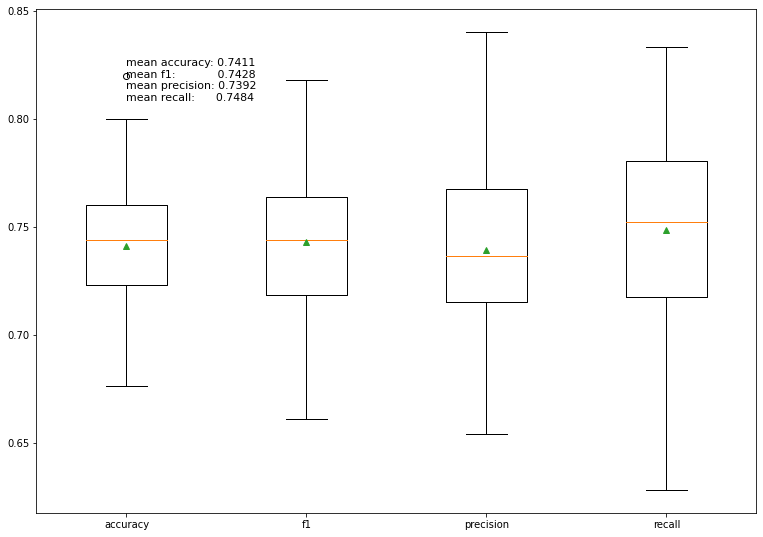

  0%|          | 0/100 [00:00<?, ?it/s]


2 SITES:



100%|██████████| 100/100 [00:04<00:00, 23.11it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.759859  0.781880     0.803901
1         f1     0.760058  0.783739     0.807419
2  precision     0.745926  0.778176     0.810426
3     recall     0.757110  0.790767     0.824423


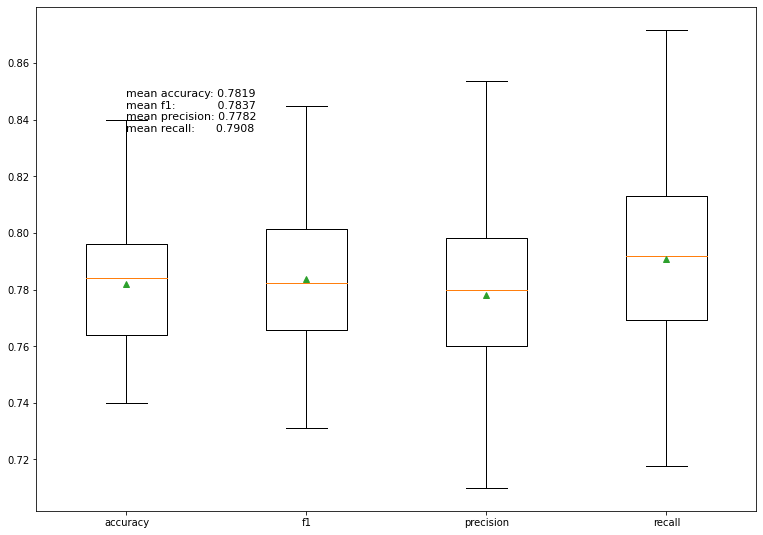

  0%|          | 0/100 [00:00<?, ?it/s]


3 SITES:



100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.806481  0.823320     0.840159
1         f1     0.803291  0.821925     0.840560
2  precision     0.787504  0.823215     0.858926
3     recall     0.793582  0.822341     0.851099


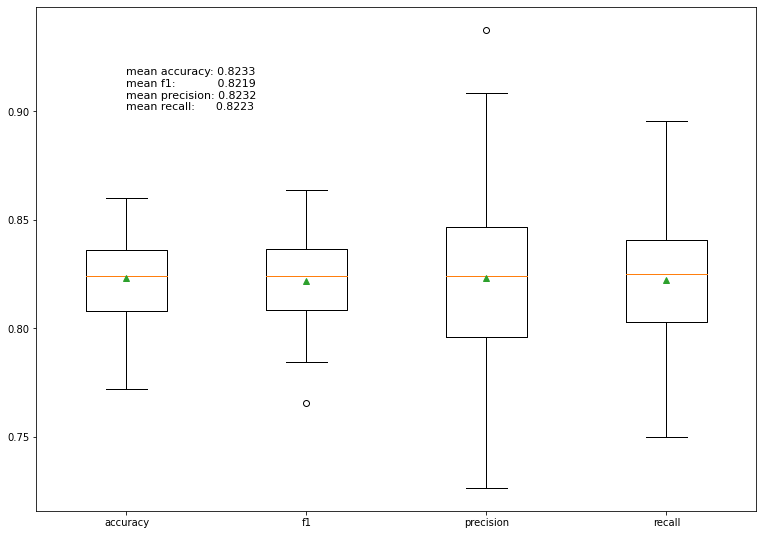

  0%|          | 0/100 [00:00<?, ?it/s]


4 SITES:



100%|██████████| 100/100 [00:09<00:00, 10.91it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.830813  0.850280     0.869747
1         f1     0.830518  0.851012     0.871505
2  precision     0.823132  0.852719     0.882306
3     recall     0.817001  0.850687     0.884373


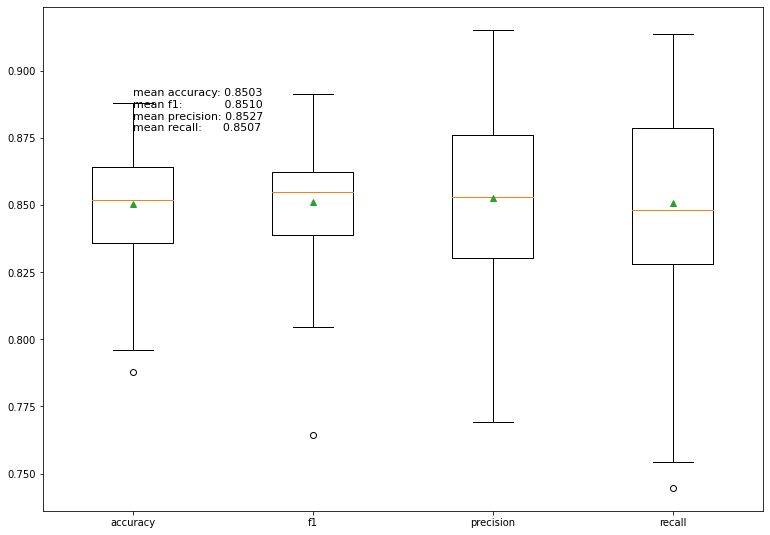

  0%|          | 0/100 [00:00<?, ?it/s]


5 SITES:



100%|██████████| 100/100 [00:11<00:00,  8.38it/s]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.837711  0.857640     0.877569
1         f1     0.836232  0.856845     0.877459
2  precision     0.824319  0.856776     0.889233
3     recall     0.825748  0.858419     0.891090


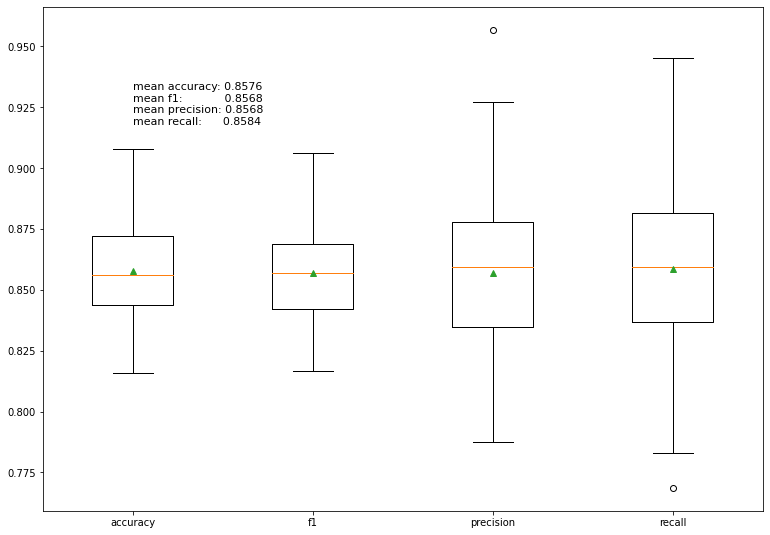

  0%|          | 0/100 [00:00<?, ?it/s]


6 SITES:



100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.846386  0.866680     0.886974
1         f1     0.843073  0.864734     0.886394
2  precision     0.846049  0.874553     0.903058
3     recall     0.824547  0.856137     0.887727


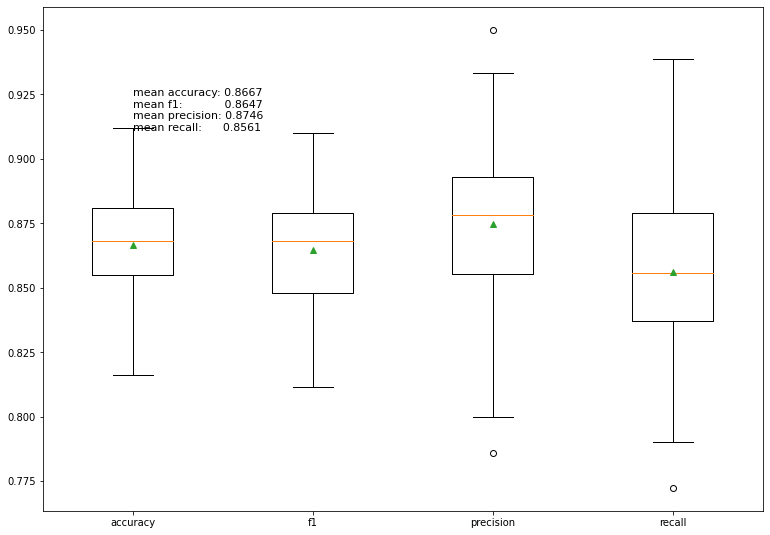

  0%|          | 0/100 [00:00<?, ?it/s]


7 SITES:



100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.849341  0.866720     0.884099
1         f1     0.845753  0.865314     0.884876
2  precision     0.843926  0.873916     0.903906
3     recall     0.830317  0.857887     0.885457


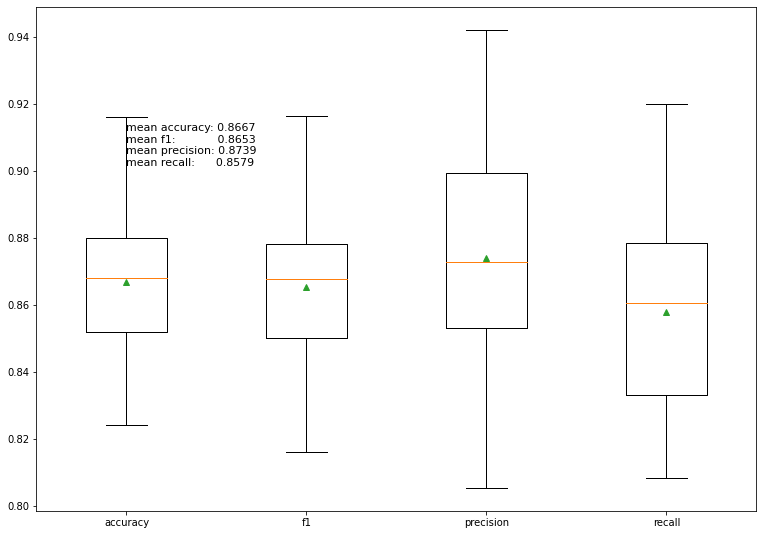

  0%|          | 0/100 [00:00<?, ?it/s]


8 SITES:



100%|██████████| 100/100 [00:18<00:00,  5.29it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.852160  0.871800     0.891440
1         f1     0.851905  0.871466     0.891027
2  precision     0.854629  0.880002     0.905375
3     recall     0.831358  0.864193     0.897028


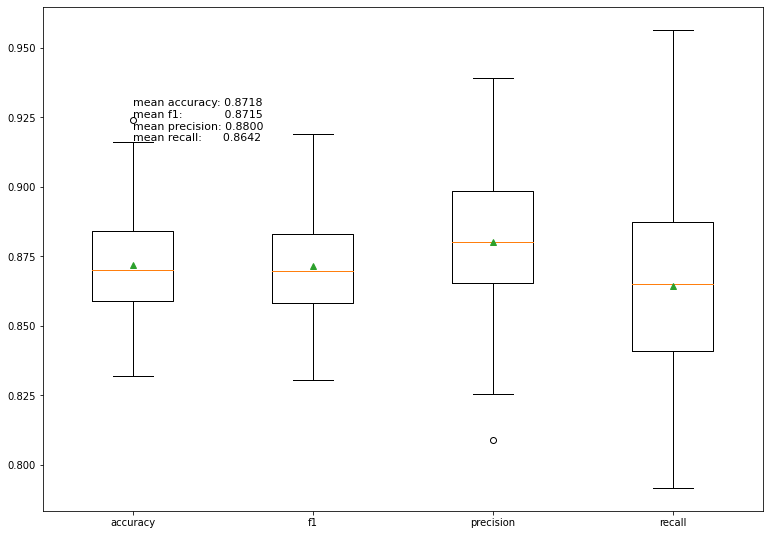

  0%|          | 0/100 [00:00<?, ?it/s]


9 SITES:



100%|██████████| 100/100 [00:22<00:00,  4.53it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.854489  0.873800     0.893111
1         f1     0.853952  0.873286     0.892619
2  precision     0.850750  0.879064     0.907379
3     recall     0.837899  0.868738     0.899577


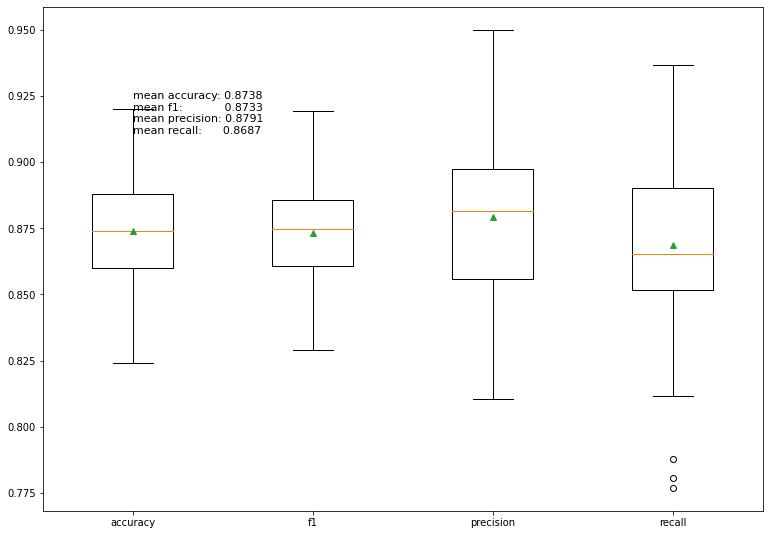

  0%|          | 0/100 [00:00<?, ?it/s]


10 SITES:



100%|██████████| 100/100 [00:24<00:00,  4.01it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.855390  0.874480     0.893570
1         f1     0.851545  0.872913     0.894281
2  precision     0.852214  0.881442     0.910670
3     recall     0.834017  0.865606     0.897195


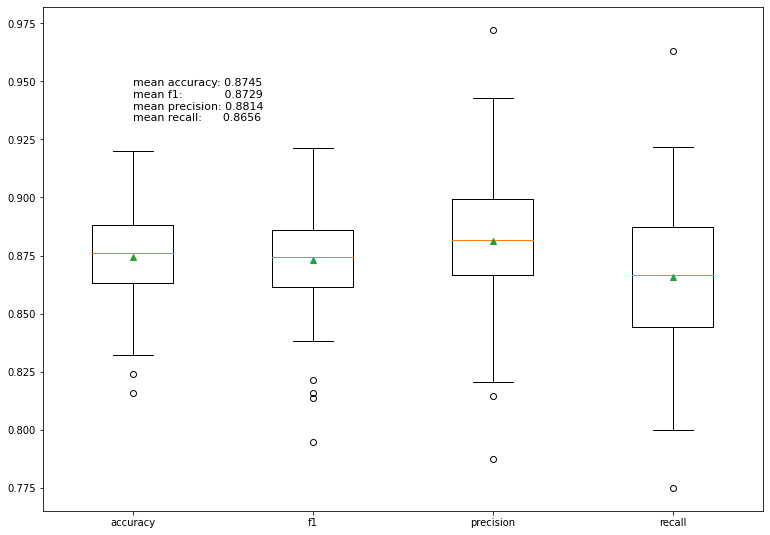

  0%|          | 0/100 [00:00<?, ?it/s]


11 SITES:



100%|██████████| 100/100 [00:27<00:00,  3.64it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.865921  0.883320     0.900719
1         f1     0.862369  0.881321     0.900273
2  precision     0.865180  0.890850     0.916519
3     recall     0.843584  0.872895     0.902206


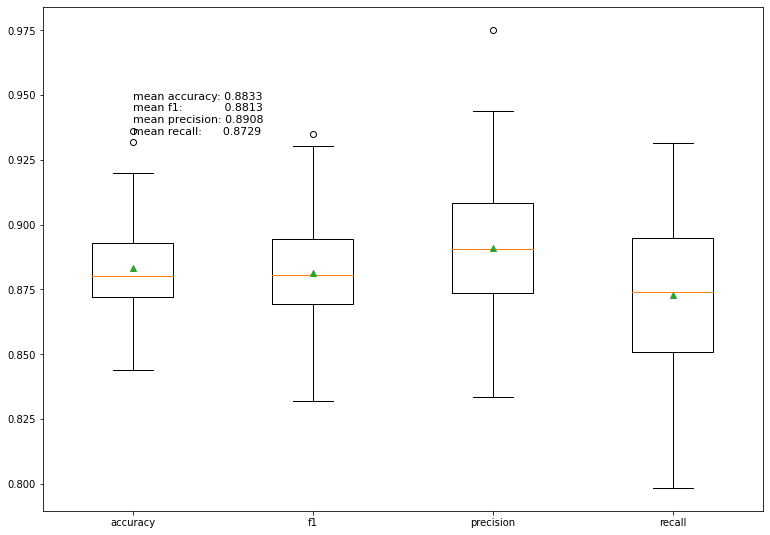

  0%|          | 0/100 [00:00<?, ?it/s]


12 SITES:



100%|██████████| 100/100 [00:29<00:00,  3.44it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.864720  0.884560     0.904400
1         f1     0.863627  0.883583     0.903538
2  precision     0.871877  0.899059     0.926240
3     recall     0.840125  0.869534     0.898943


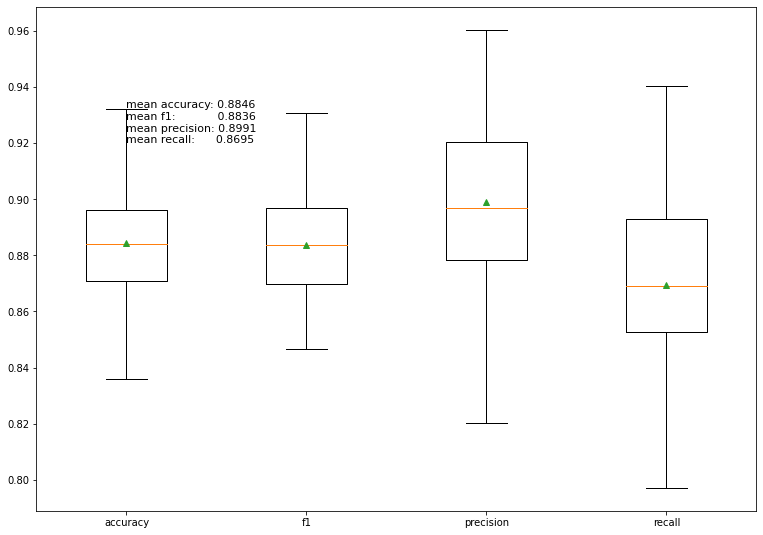

  0%|          | 0/100 [00:00<?, ?it/s]


13 SITES:



100%|██████████| 100/100 [00:31<00:00,  3.16it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.870996  0.887800     0.904604
1         f1     0.866536  0.885037     0.903539
2  precision     0.872838  0.900006     0.927174
3     recall     0.841593  0.871621     0.901649


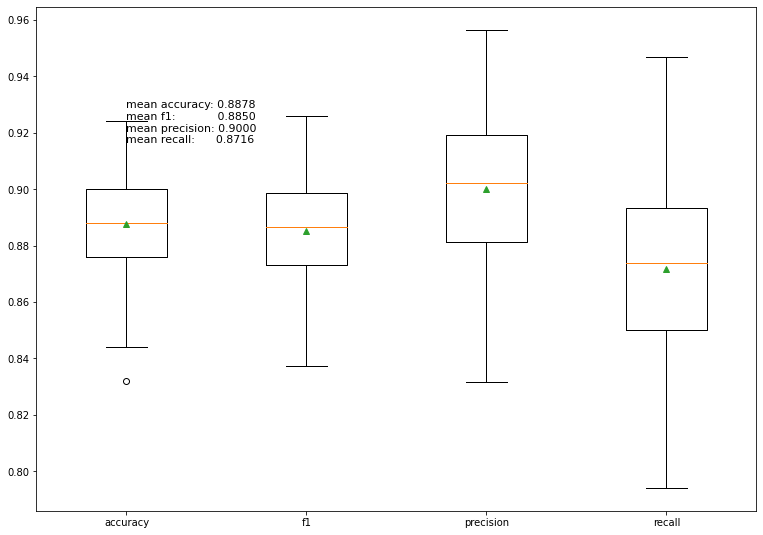

  0%|          | 0/100 [00:00<?, ?it/s]


14 SITES:



100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.873545  0.891080     0.908615
1         f1     0.870083  0.888457     0.906831
2  precision     0.874395  0.901001     0.927606
3     recall     0.849430  0.877142     0.904854


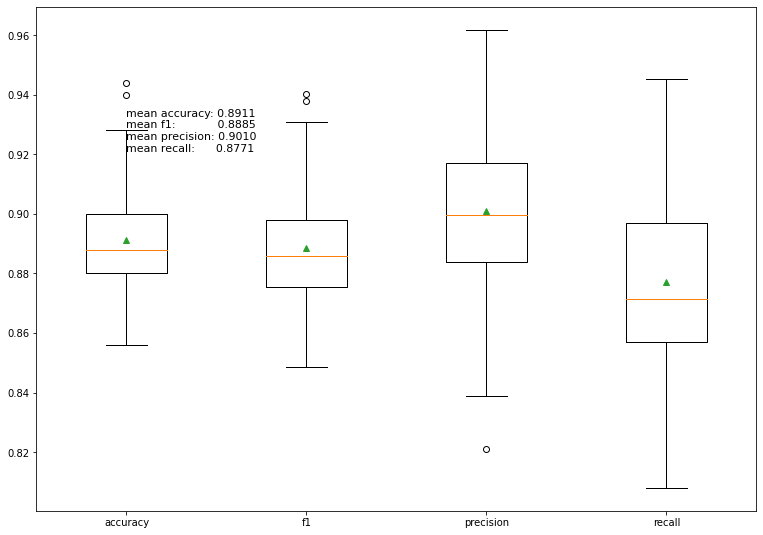

  0%|          | 0/100 [00:00<?, ?it/s]


15 SITES:



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.879041  0.895200     0.911359
1         f1     0.874519  0.892602     0.910684
2  precision     0.884441  0.910839     0.937236
3     recall     0.845435  0.876177     0.906920


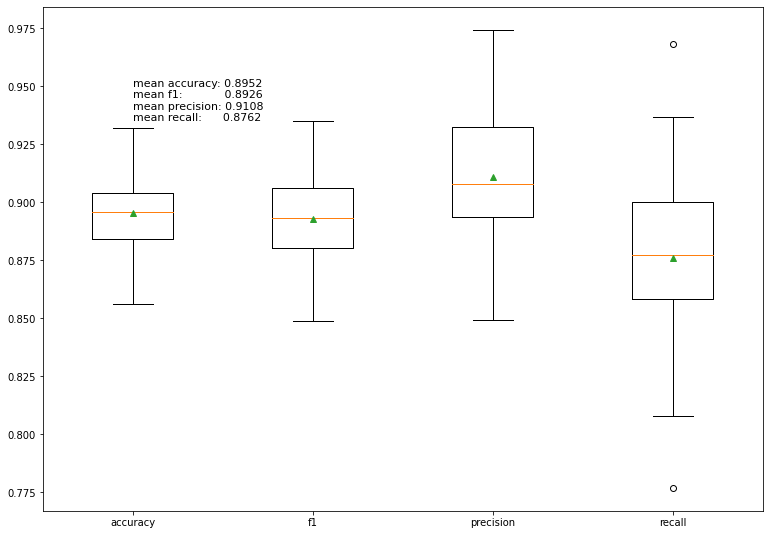

  0%|          | 0/100 [00:00<?, ?it/s]


16 SITES:



100%|██████████| 100/100 [00:37<00:00,  2.64it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.872571  0.891920     0.911269
1         f1     0.868903  0.889666     0.910430
2  precision     0.874149  0.903845     0.933542
3     recall     0.845324  0.877072     0.908820


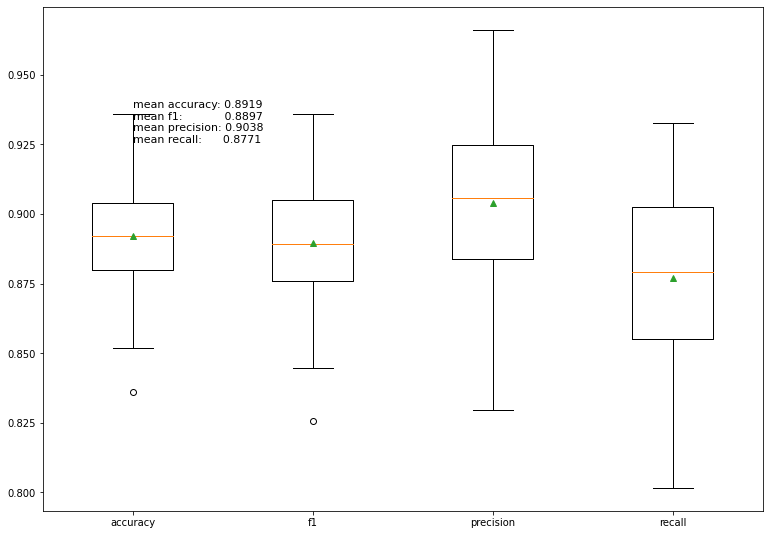

  0%|          | 0/100 [00:00<?, ?it/s]


17 SITES:



100%|██████████| 100/100 [00:40<00:00,  2.46it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.876468  0.892920     0.909372
1         f1     0.873025  0.891019     0.909014
2  precision     0.876496  0.901466     0.926436
3     recall     0.854297  0.881620     0.908944


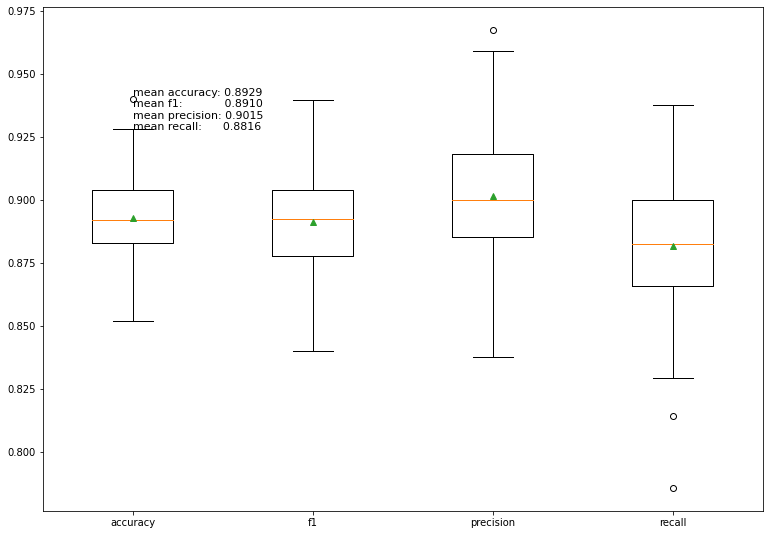

  0%|          | 0/100 [00:00<?, ?it/s]


18 SITES:



100%|██████████| 100/100 [00:43<00:00,  2.31it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.871576  0.888240     0.904904
1         f1     0.867608  0.885807     0.904007
2  precision     0.874362  0.902149     0.929936
3     recall     0.842741  0.871039     0.899337


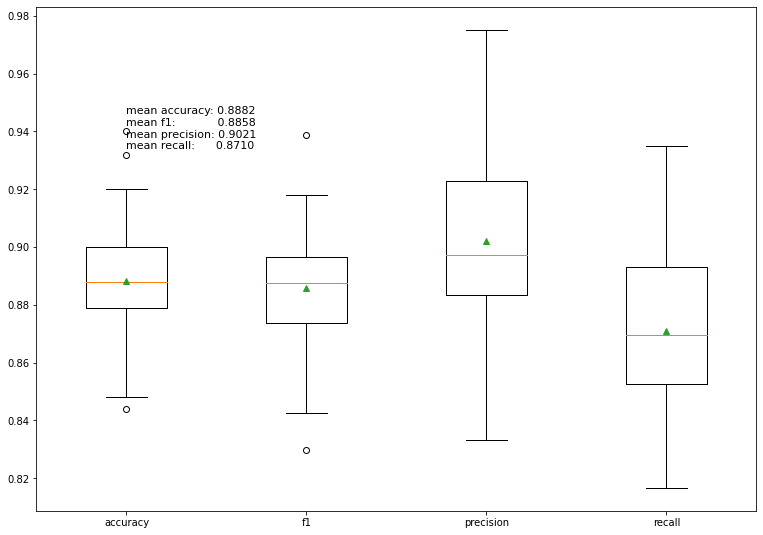

  0%|          | 0/100 [00:00<?, ?it/s]


19 SITES:



100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.880655  0.897920     0.915185
1         f1     0.877936  0.896461     0.914987
2  precision     0.891490  0.915310     0.939131
3     recall     0.851954  0.879041     0.906128


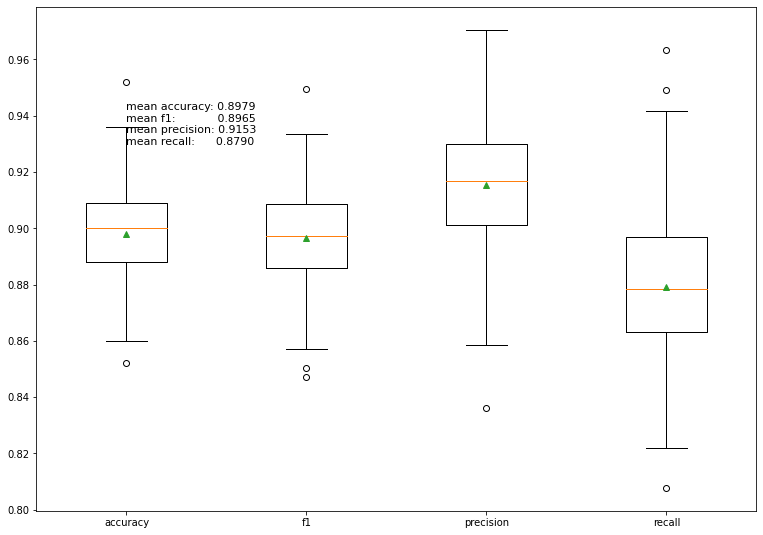

  0%|          | 0/100 [00:00<?, ?it/s]


20 SITES:



100%|██████████| 100/100 [00:51<00:00,  1.95it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.875553  0.894240     0.912927
1         f1     0.872101  0.891831     0.911561
2  precision     0.886624  0.912493     0.938363
3     recall     0.842851  0.872952     0.903052


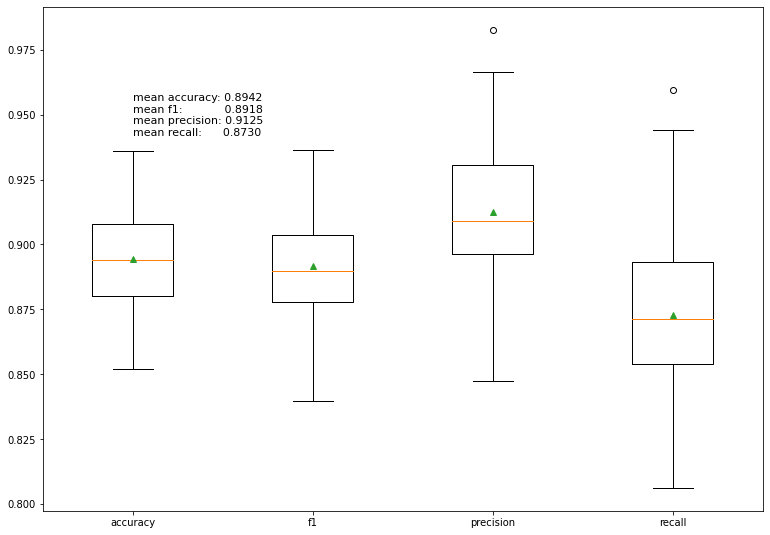

  0%|          | 0/100 [00:00<?, ?it/s]


21 SITES:



100%|██████████| 100/100 [00:55<00:00,  1.79it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.878609  0.894840     0.911071
1         f1     0.874838  0.892168     0.909498
2  precision     0.880118  0.905868     0.931618
3     recall     0.852908  0.879726     0.906545


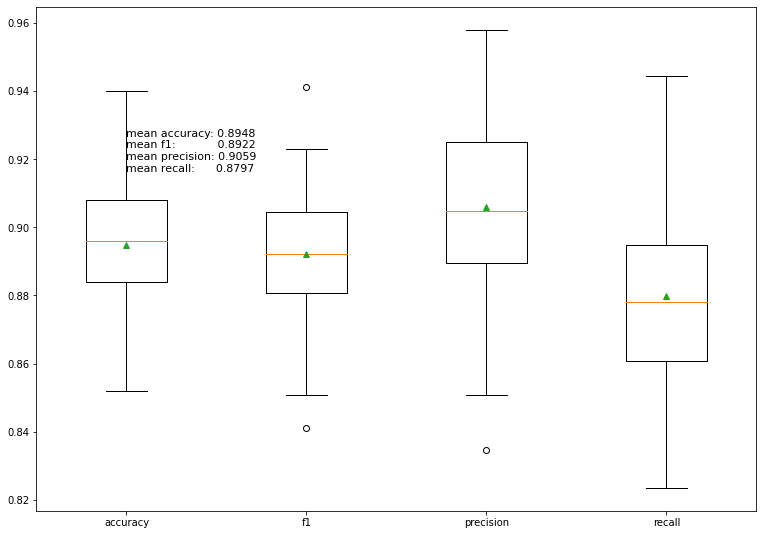

  0%|          | 0/100 [00:00<?, ?it/s]


22 SITES:



100%|██████████| 100/100 [00:59<00:00,  1.69it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.883805  0.900640     0.917475
1         f1     0.883418  0.899953     0.916489
2  precision     0.885552  0.911013     0.936473
3     recall     0.863483  0.890054     0.916625


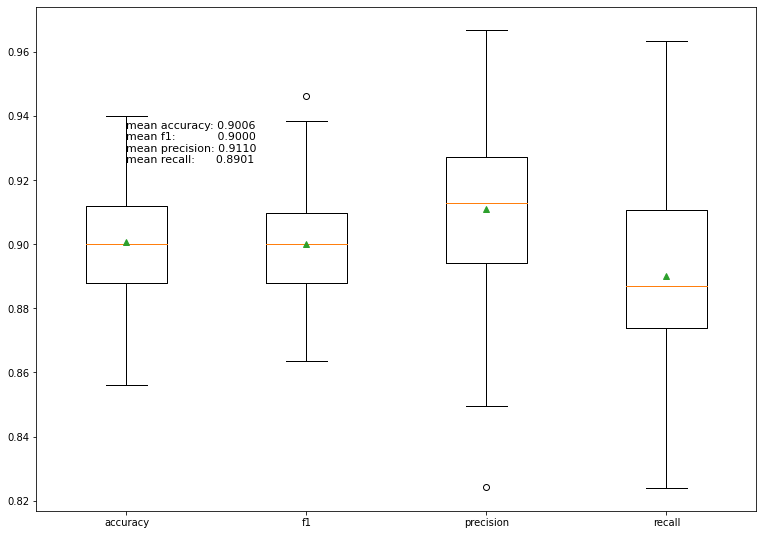

  0%|          | 0/100 [00:00<?, ?it/s]


23 SITES:



100%|██████████| 100/100 [01:02<00:00,  1.59it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.882089  0.898520     0.914951
1         f1     0.879224  0.897142     0.915060
2  precision     0.886343  0.912284     0.938224
3     recall     0.854518  0.883453     0.912387


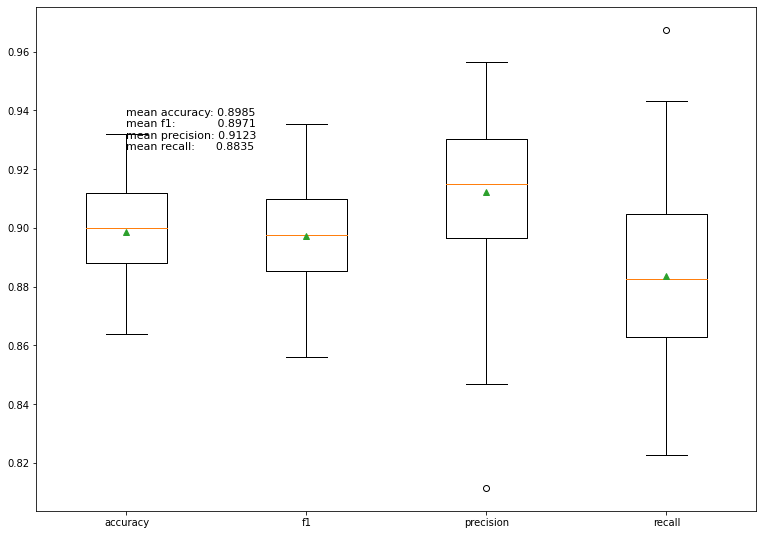

  0%|          | 0/100 [00:00<?, ?it/s]


24 SITES:



100%|██████████| 100/100 [03:25<00:00,  2.05s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.880616  0.898120     0.915624
1         f1     0.878462  0.896835     0.915209
2  precision     0.878343  0.903945     0.929546
3     recall     0.863643  0.890620     0.917597


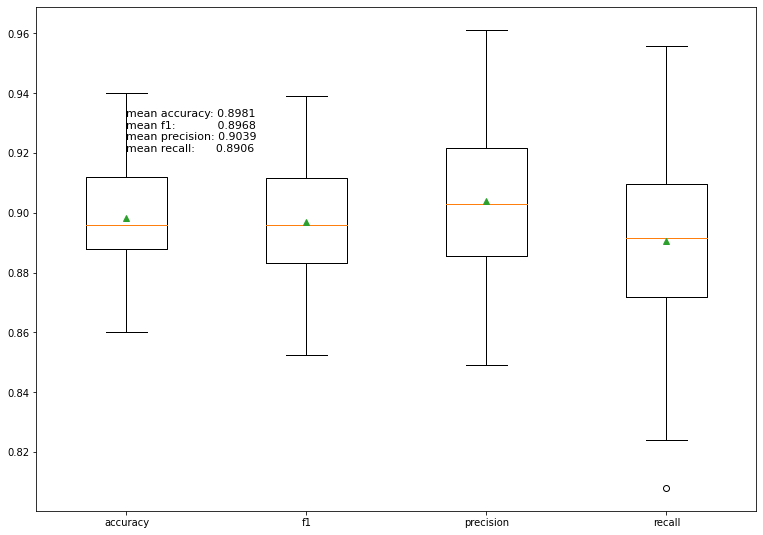

  0%|          | 0/100 [00:00<?, ?it/s]


25 SITES:



100%|██████████| 100/100 [01:09<00:00,  1.44it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.887417  0.904040     0.920663
1         f1     0.885289  0.902475     0.919661
2  precision     0.887037  0.911900     0.936764
3     recall     0.866491  0.894117     0.921743


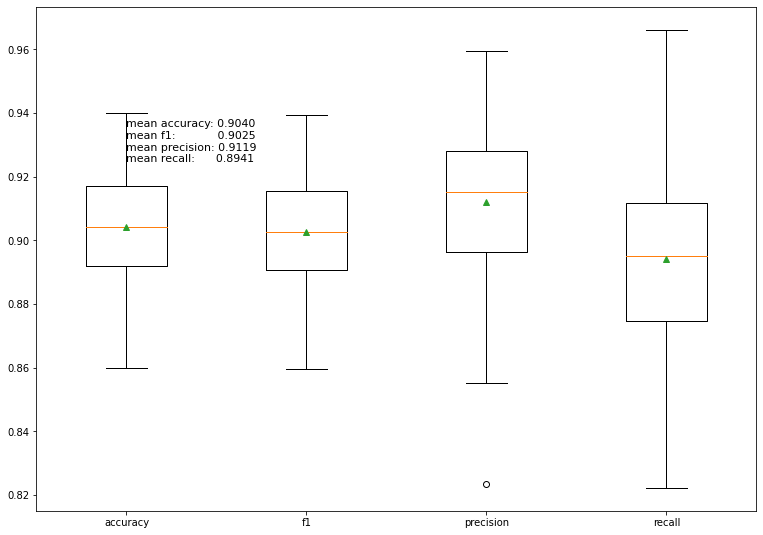

  0%|          | 0/100 [00:00<?, ?it/s]


26 SITES:



100%|██████████| 100/100 [01:12<00:00,  1.37it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.888047  0.904200     0.920353
1         f1     0.886941  0.903183     0.919425
2  precision     0.886303  0.911138     0.935973
3     recall     0.868489  0.896312     0.924136


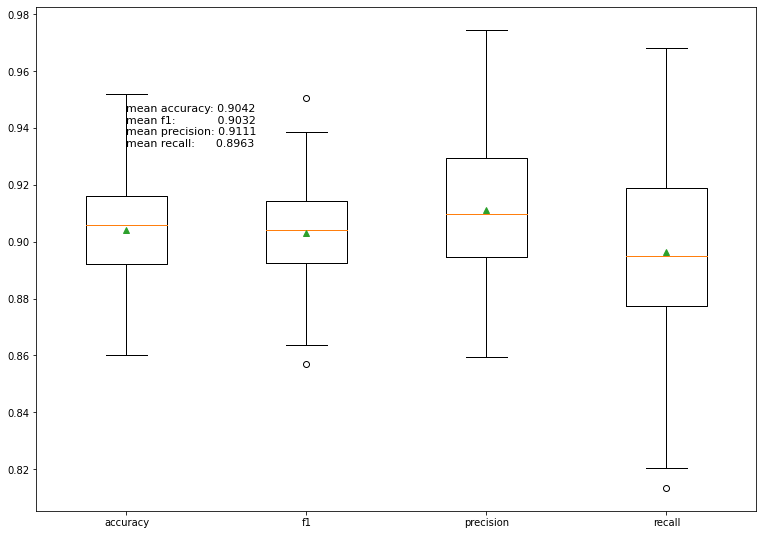

  0%|          | 0/100 [00:00<?, ?it/s]


27 SITES:



100%|██████████| 100/100 [01:14<00:00,  1.35it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.894825  0.909440     0.924055
1         f1     0.891890  0.908340     0.924789
2  precision     0.892579  0.915701     0.938823
3     recall     0.875390  0.901874     0.928357


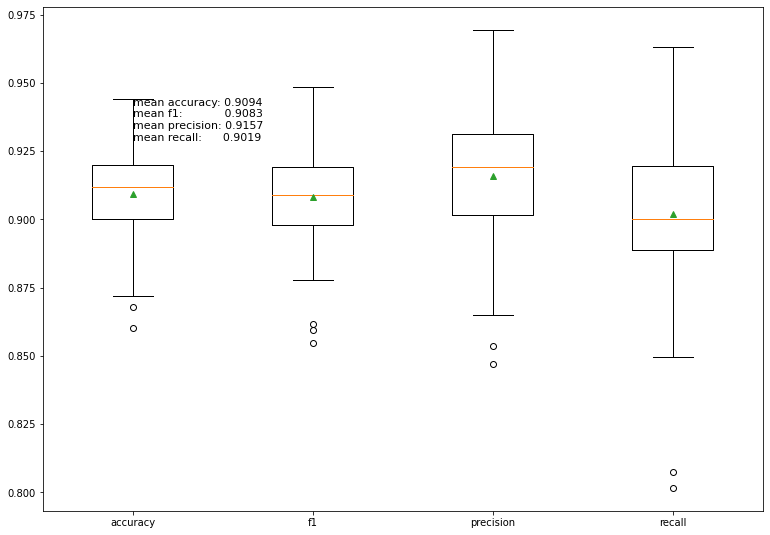

  0%|          | 0/100 [00:00<?, ?it/s]


28 SITES:



100%|██████████| 100/100 [01:16<00:00,  1.30it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.896421  0.911840     0.927259
1         f1     0.893858  0.910414     0.926970
2  precision     0.895325  0.920580     0.945836
3     recall     0.874912  0.901346     0.927780


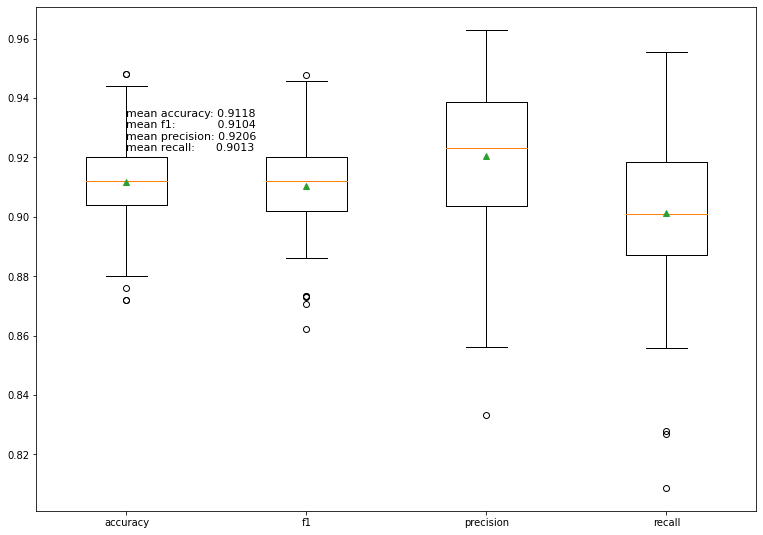

  0%|          | 0/100 [00:00<?, ?it/s]


29 SITES:



100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.896954  0.912880     0.928806
1         f1     0.895752  0.911989     0.928225
2  precision     0.902825  0.924590     0.946356
3     recall     0.874203  0.900428     0.926653


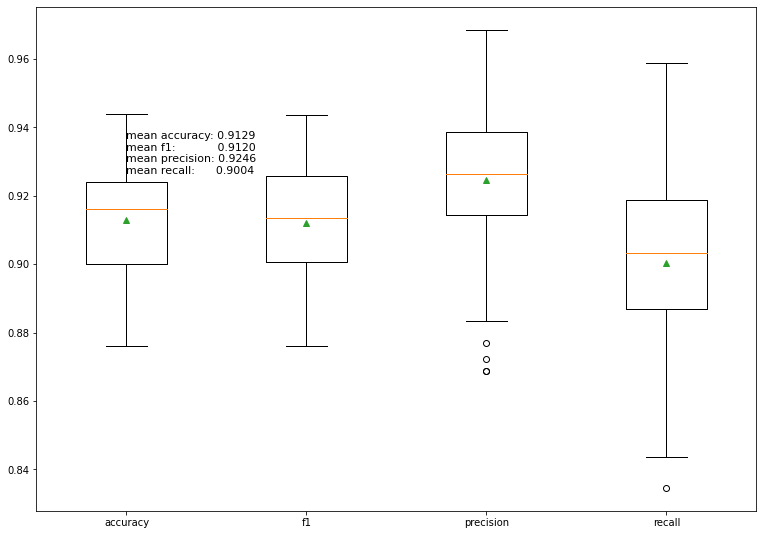

  0%|          | 0/100 [00:00<?, ?it/s]


30 SITES:



100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.897850  0.913080     0.928310
1         f1     0.896176  0.912549     0.928922
2  precision     0.897215  0.921155     0.945096
3     recall     0.878959  0.904887     0.930814


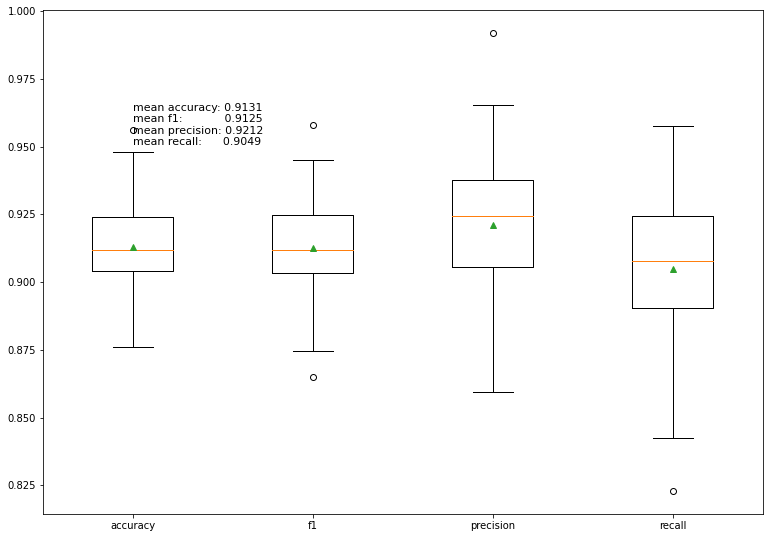

  0%|          | 0/100 [00:00<?, ?it/s]


31 SITES:



100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.894348  0.911080     0.927812
1         f1     0.891509  0.909501     0.927494
2  precision     0.899390  0.921396     0.943402
3     recall     0.871562  0.898537     0.925512


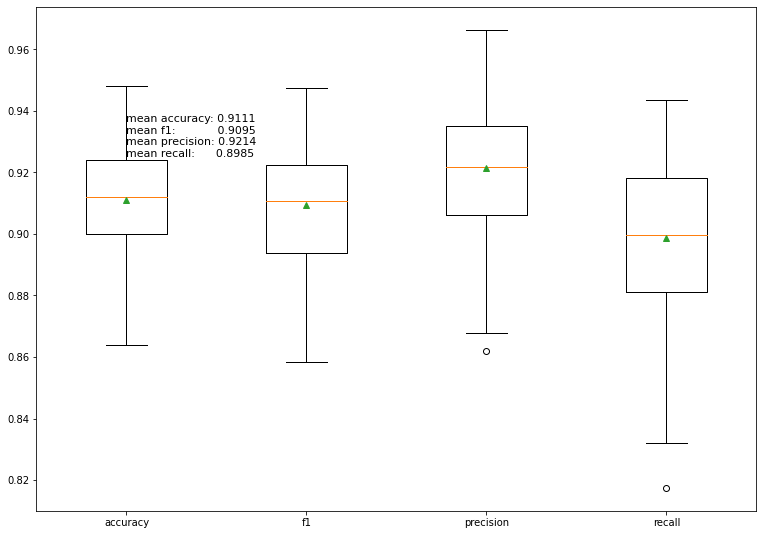

  0%|          | 0/100 [00:00<?, ?it/s]


32 SITES:



100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.894510  0.910400     0.926290
1         f1     0.892805  0.909277     0.925749
2  precision     0.896561  0.919134     0.941707
3     recall     0.875151  0.900285     0.925419


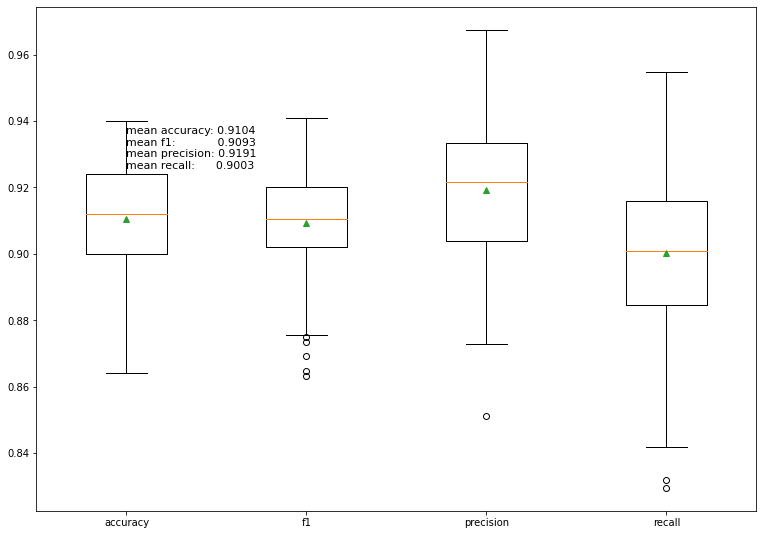

  0%|          | 0/100 [00:00<?, ?it/s]


33 SITES:



100%|██████████| 100/100 [01:28<00:00,  1.12it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.894152  0.910400     0.926648
1         f1     0.892711  0.909171     0.925632
2  precision     0.898222  0.920268     0.942314
3     recall     0.872873  0.899019     0.925165


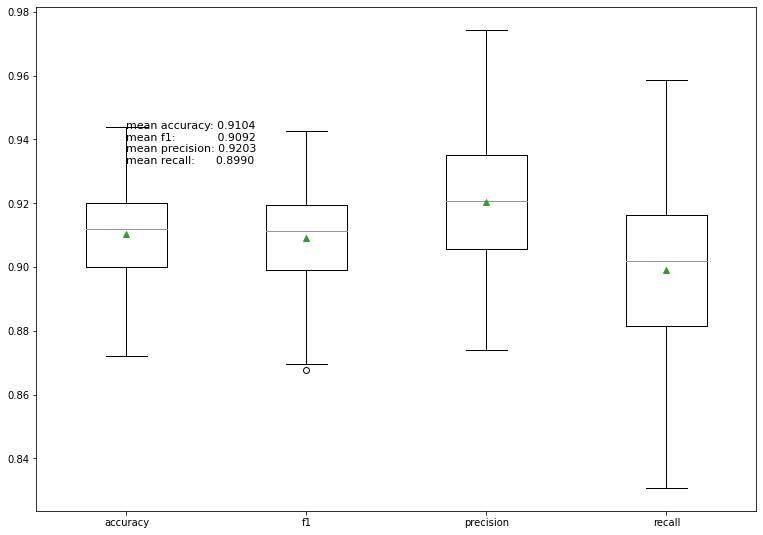

  0%|          | 0/100 [00:00<?, ?it/s]


34 SITES:



100%|██████████| 100/100 [01:33<00:00,  1.07it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.901040  0.915640     0.930240
1         f1     0.899256  0.914861     0.930467
2  precision     0.899321  0.922087     0.944853
3     recall     0.883608  0.908459     0.933310


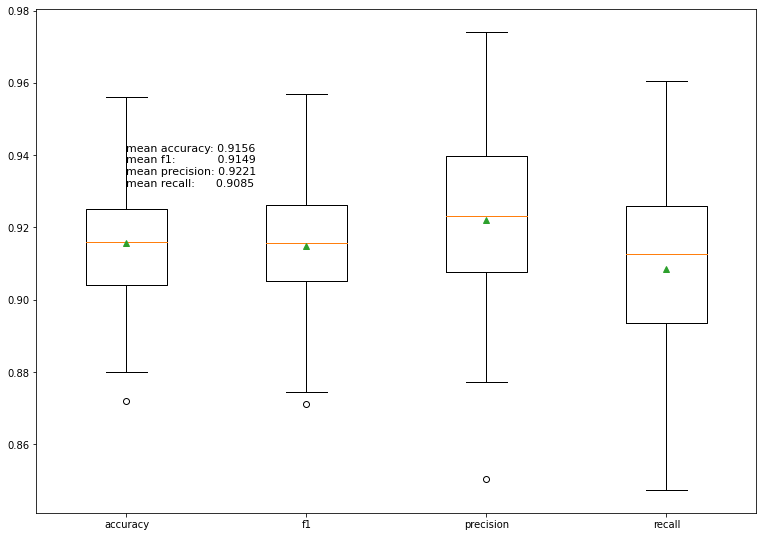

  0%|          | 0/100 [00:00<?, ?it/s]


35 SITES:



100%|██████████| 100/100 [01:37<00:00,  1.03it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.902433  0.916360     0.930287
1         f1     0.901306  0.915095     0.928884
2  precision     0.906336  0.926087     0.945838
3     recall     0.880557  0.905026     0.929495


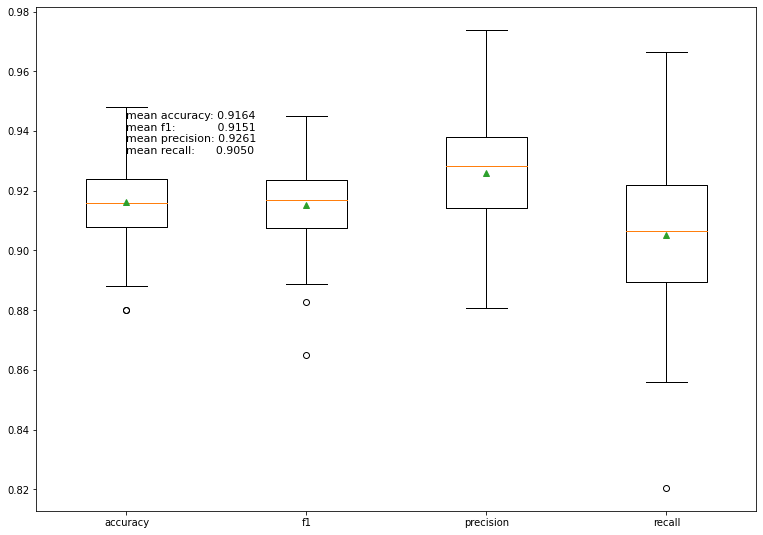

  0%|          | 0/100 [00:00<?, ?it/s]


36 SITES:



100%|██████████| 100/100 [01:38<00:00,  1.02it/s]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.904046  0.920320     0.936594
1         f1     0.902564  0.919473     0.936383
2  precision     0.902689  0.925500     0.948311
3     recall     0.890496  0.914075     0.937654


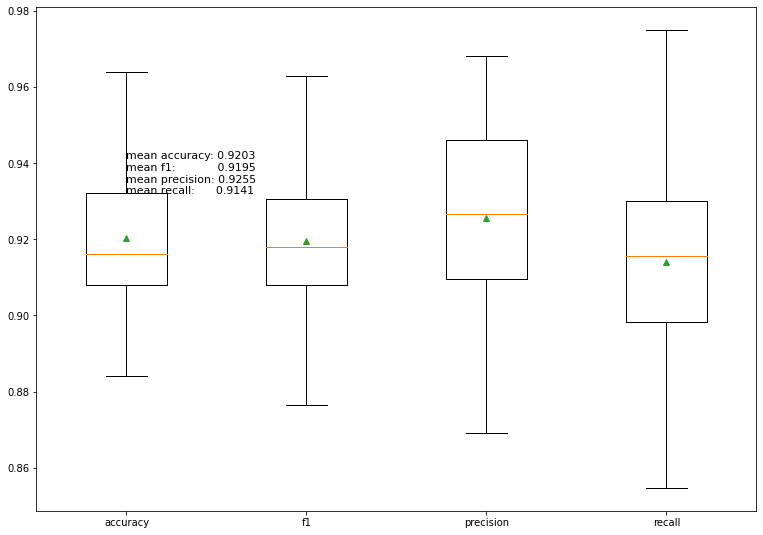

  0%|          | 0/100 [00:00<?, ?it/s]


37 SITES:



100%|██████████| 100/100 [01:40<00:00,  1.01s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.902698  0.918640     0.934582
1         f1     0.900024  0.917337     0.934650
2  precision     0.903321  0.927380     0.951439
3     recall     0.881890  0.908247     0.934604


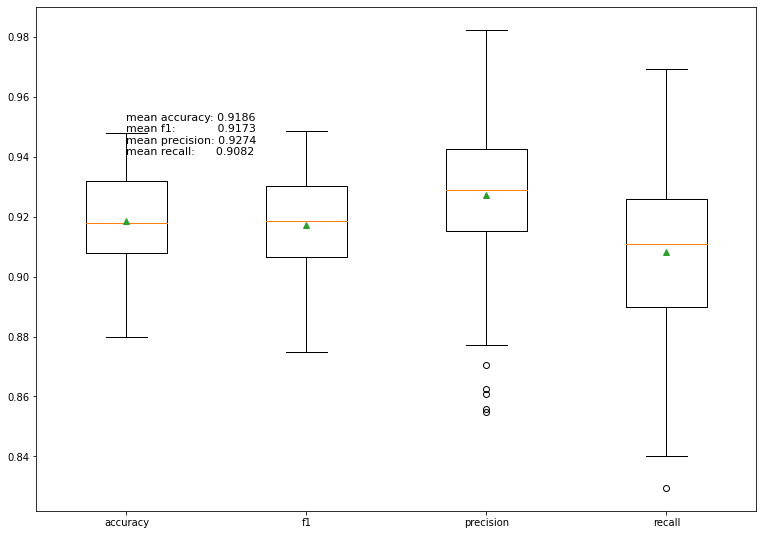

  0%|          | 0/100 [00:00<?, ?it/s]


38 SITES:



100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.905567  0.920240     0.934913
1         f1     0.903373  0.919157     0.934941
2  precision     0.903923  0.926950     0.949977
3     recall     0.888104  0.912149     0.936194


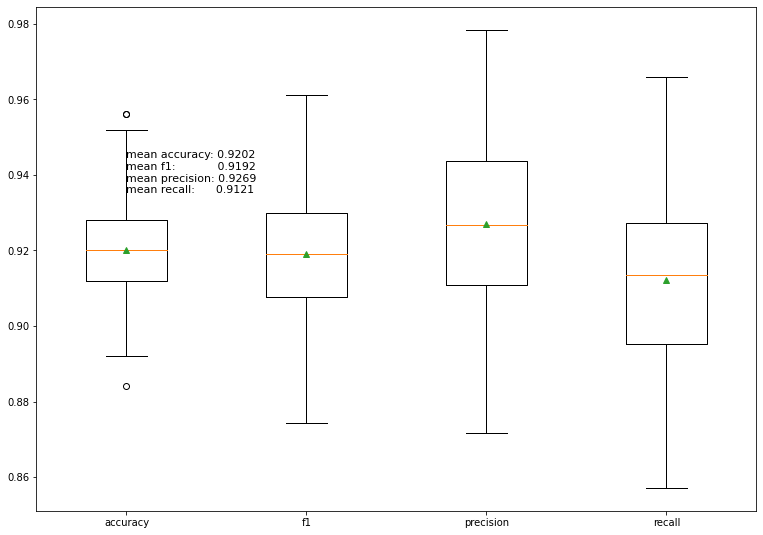

  0%|          | 0/100 [00:00<?, ?it/s]


39 SITES:



100%|██████████| 100/100 [01:45<00:00,  1.06s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.904744  0.920440     0.936136
1         f1     0.905047  0.920352     0.935657
2  precision     0.909340  0.927505     0.945669
3     recall     0.889211  0.913818     0.938425


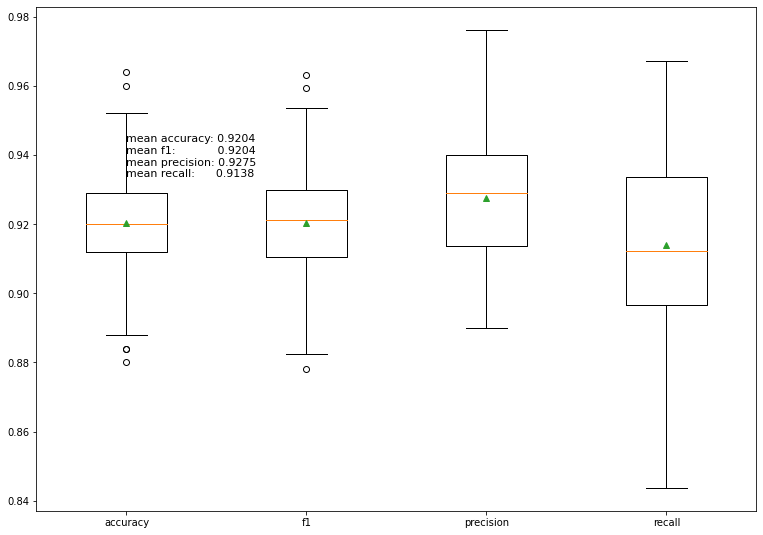

  0%|          | 0/100 [00:00<?, ?it/s]


40 SITES:



100%|██████████| 100/100 [01:48<00:00,  1.09s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.906729  0.921720     0.936711
1         f1     0.905701  0.920718     0.935735
2  precision     0.910045  0.930615     0.951184
3     recall     0.887899  0.911619     0.935340


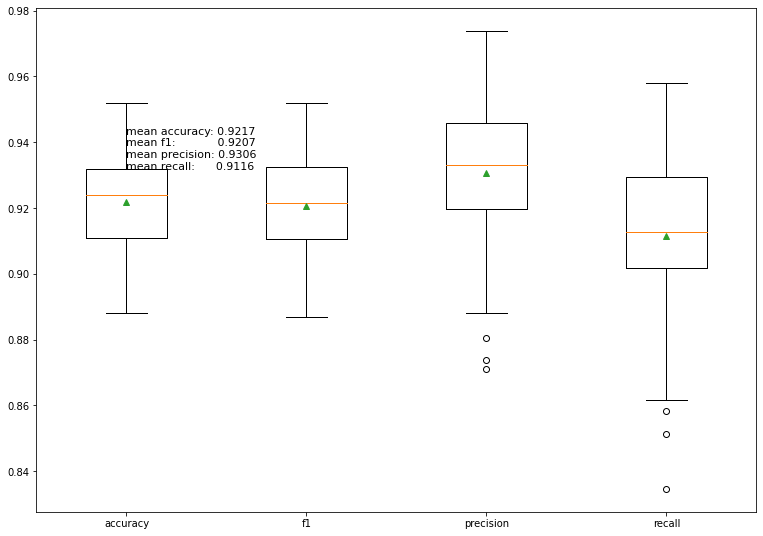

  0%|          | 0/100 [00:00<?, ?it/s]


41 SITES:



100%|██████████| 100/100 [01:49<00:00,  1.10s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.909088  0.922320     0.935552
1         f1     0.906875  0.920968     0.935061
2  precision     0.905696  0.924902     0.944108
3     recall     0.895215  0.917576     0.939936


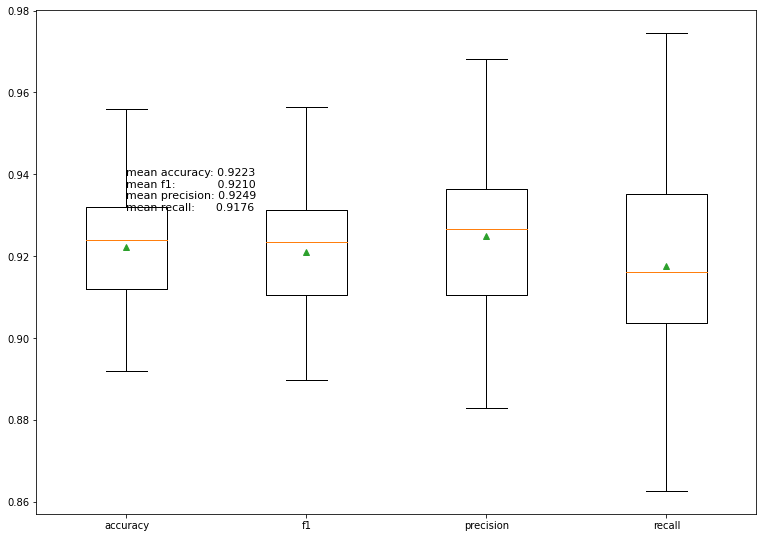

  0%|          | 0/100 [00:00<?, ?it/s]


42 SITES:



100%|██████████| 100/100 [01:52<00:00,  1.12s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911978  0.926800     0.941622
1         f1     0.911472  0.926173     0.940873
2  precision     0.907885  0.930381     0.952878
3     recall     0.899181  0.922691     0.946202


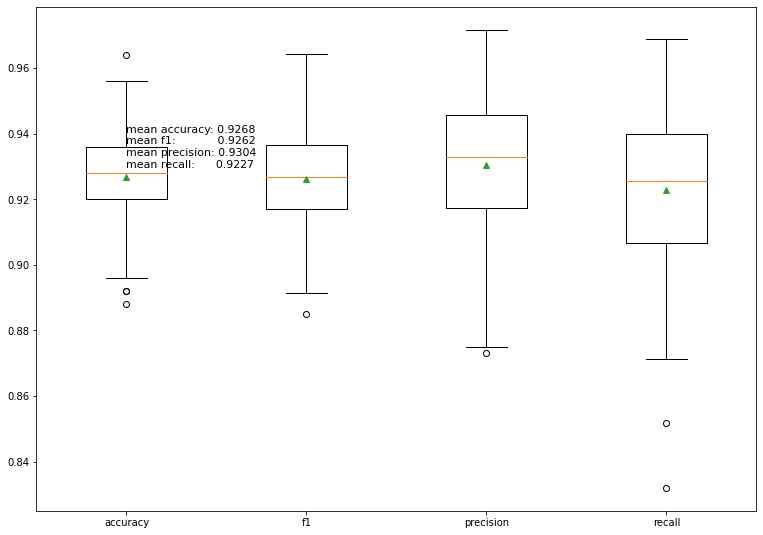

  0%|          | 0/100 [00:00<?, ?it/s]


43 SITES:



100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.909953  0.924440     0.938927
1         f1     0.907677  0.923313     0.938948
2  precision     0.910516  0.930788     0.951060
3     recall     0.891078  0.916583     0.942087


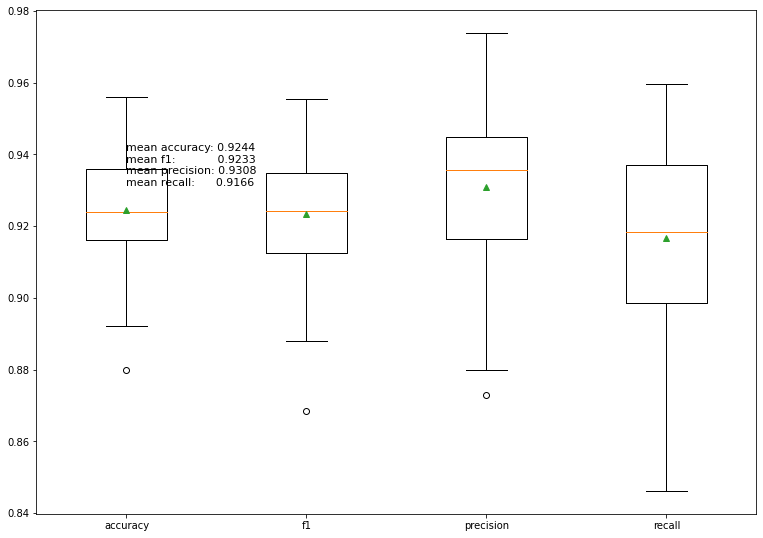

  0%|          | 0/100 [00:00<?, ?it/s]


44 SITES:



100%|██████████| 100/100 [01:57<00:00,  1.18s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.910481  0.927240     0.943999
1         f1     0.909817  0.926837     0.943856
2  precision     0.908281  0.932445     0.956610
3     recall     0.898533  0.921876     0.945220


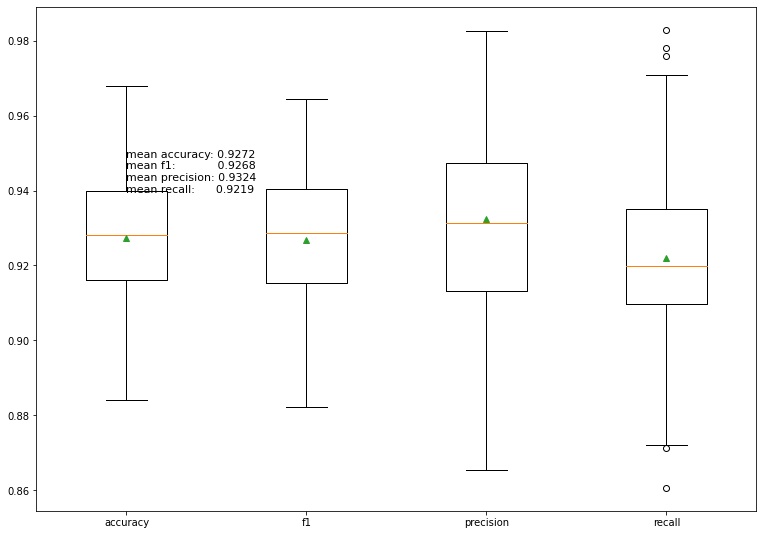

  0%|          | 0/100 [00:00<?, ?it/s]


45 SITES:



100%|██████████| 100/100 [04:03<00:00,  2.44s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911691  0.924800     0.937909
1         f1     0.910710  0.924044     0.937379
2  precision     0.910238  0.930027     0.949815
3     recall     0.897054  0.918680     0.940305


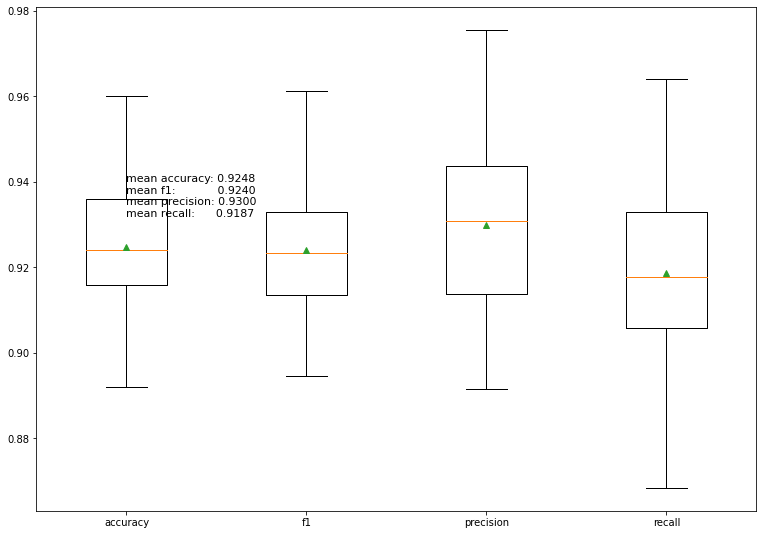

  0%|          | 0/100 [00:00<?, ?it/s]


46 SITES:



100%|██████████| 100/100 [02:03<00:00,  1.23s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.908176  0.924040     0.939904
1         f1     0.907236  0.923527     0.939818
2  precision     0.906460  0.930502     0.954543
3     recall     0.892580  0.917375     0.942170


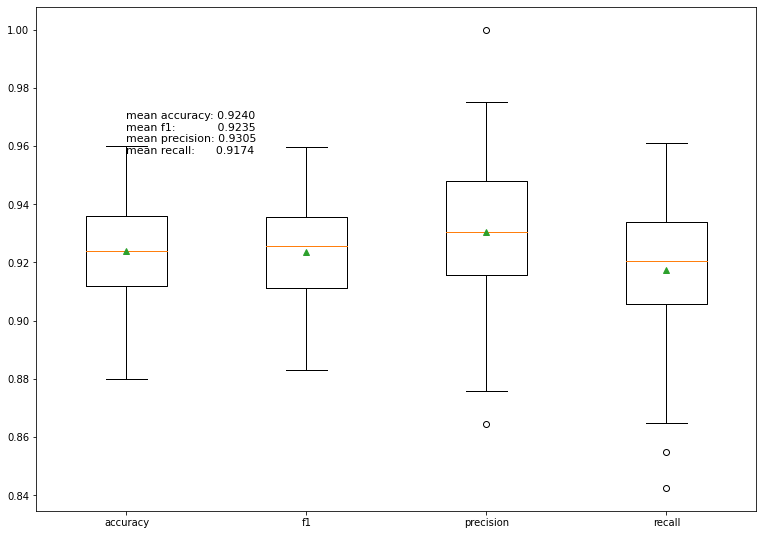

  0%|          | 0/100 [00:00<?, ?it/s]


47 SITES:



100%|██████████| 100/100 [02:07<00:00,  1.27s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.908173  0.923560     0.938947
1         f1     0.906894  0.922714     0.938534
2  precision     0.906981  0.926270     0.945558
3     recall     0.897215  0.919597     0.941978


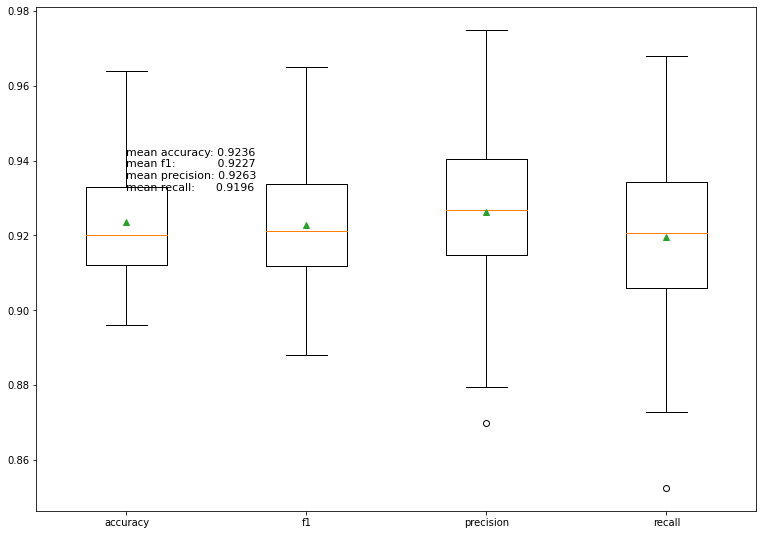

  0%|          | 0/100 [00:00<?, ?it/s]


48 SITES:



100%|██████████| 100/100 [02:04<00:00,  1.25s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911351  0.925560     0.939769
1         f1     0.909667  0.924638     0.939609
2  precision     0.906668  0.927727     0.948786
3     recall     0.897937  0.922200     0.946463


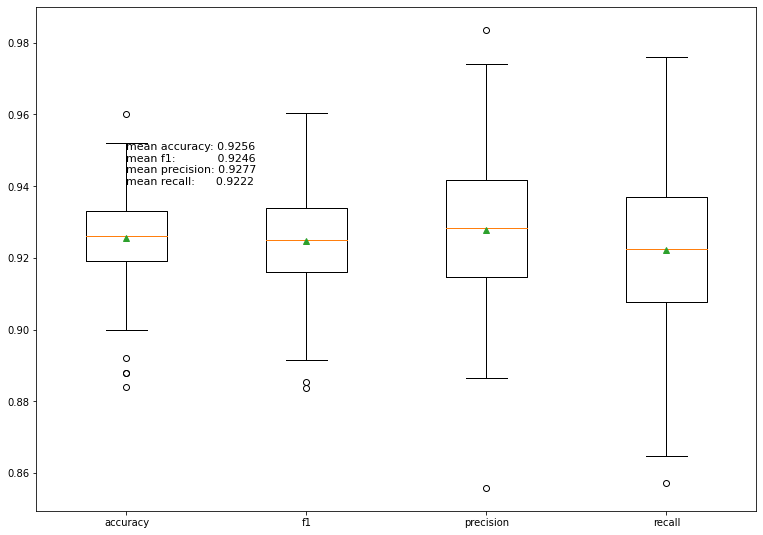

  0%|          | 0/100 [00:00<?, ?it/s]


49 SITES:



100%|██████████| 100/100 [02:07<00:00,  1.27s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.909928  0.924400     0.938872
1         f1     0.908914  0.923741     0.938568
2  precision     0.909860  0.932184     0.954507
3     recall     0.891346  0.916182     0.941018


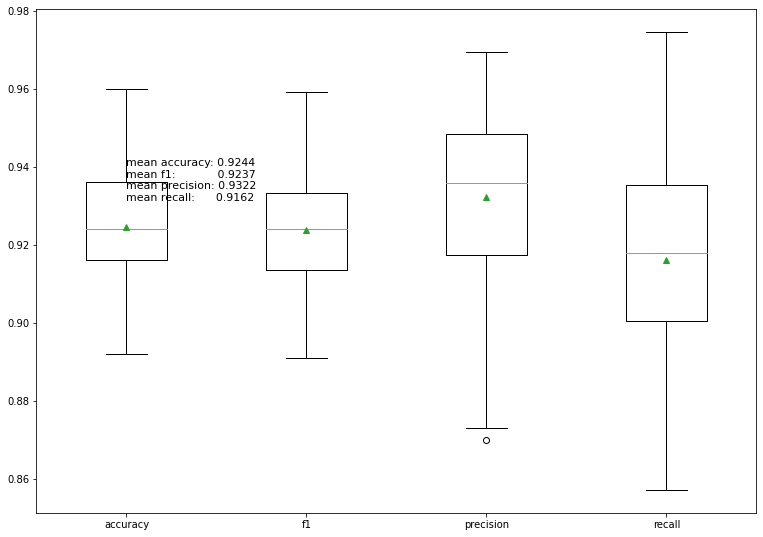

  0%|          | 0/100 [00:00<?, ?it/s]


50 SITES:



100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.909711  0.924920     0.940129
1         f1     0.909062  0.924353     0.939644
2  precision     0.910164  0.931212     0.952261
3     recall     0.897330  0.918027     0.938723


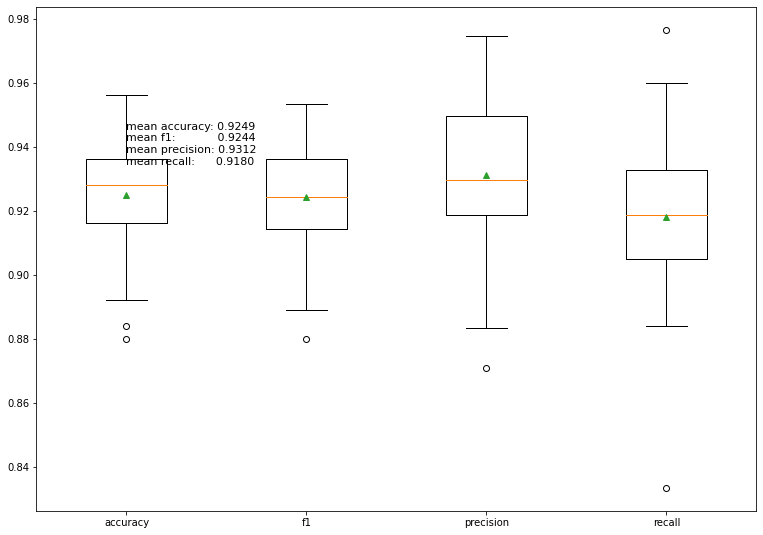

  0%|          | 0/100 [00:00<?, ?it/s]


51 SITES:



100%|██████████| 100/100 [02:13<00:00,  1.33s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915638  0.927960     0.940282
1         f1     0.914860  0.927698     0.940536
2  precision     0.908782  0.930618     0.952455
3     recall     0.904748  0.925421     0.946094


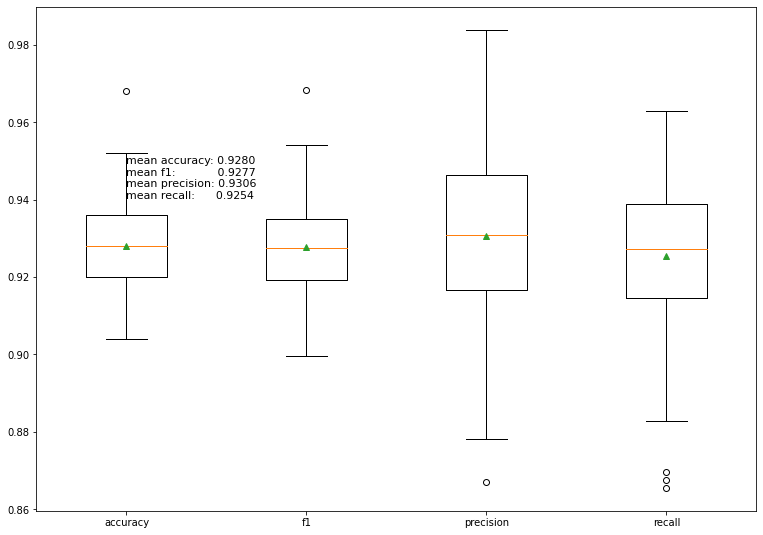

  0%|          | 0/100 [00:00<?, ?it/s]


52 SITES:



100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915243  0.928080     0.940917
1         f1     0.914819  0.928097     0.941375
2  precision     0.914359  0.934215     0.954070
3     recall     0.898712  0.922720     0.946728


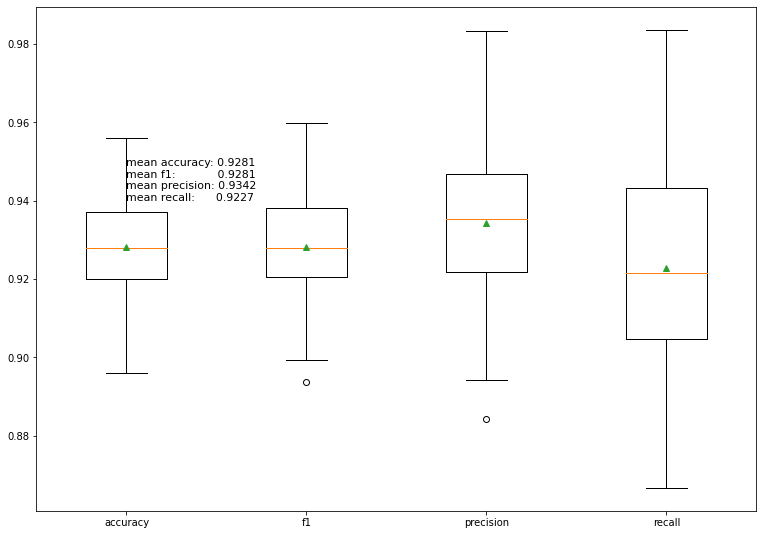

  0%|          | 0/100 [00:00<?, ?it/s]


53 SITES:



100%|██████████| 100/100 [02:19<00:00,  1.39s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911852  0.927160     0.942468
1         f1     0.911713  0.927134     0.942554
2  precision     0.910673  0.931663     0.952652
3     recall     0.900082  0.923186     0.946290


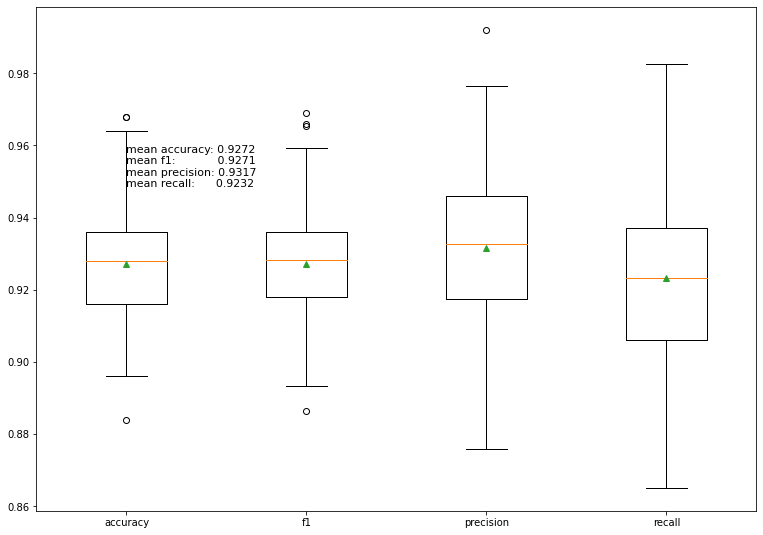

  0%|          | 0/100 [00:00<?, ?it/s]


54 SITES:



100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.913587  0.927920     0.942253
1         f1     0.911351  0.926588     0.941825
2  precision     0.909233  0.931170     0.953107
3     recall     0.901067  0.922569     0.944072


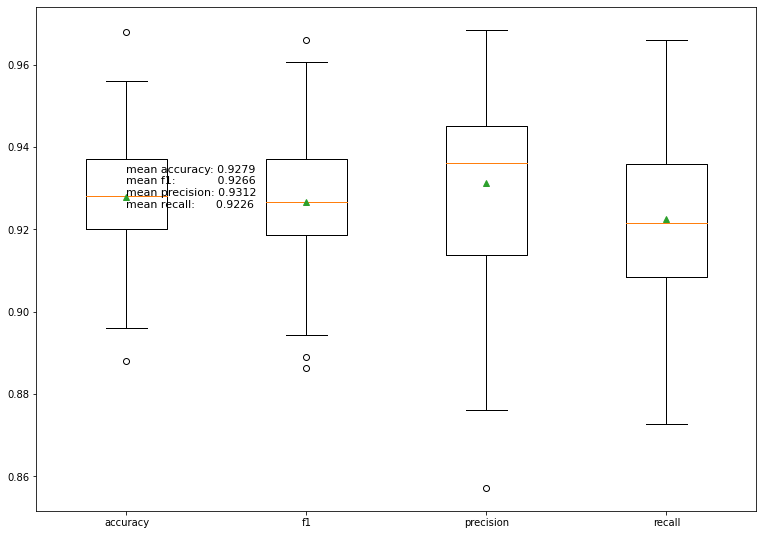

  0%|          | 0/100 [00:00<?, ?it/s]


55 SITES:



100%|██████████| 100/100 [02:23<00:00,  1.44s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911126  0.924680     0.938234
1         f1     0.909310  0.923900     0.938491
2  precision     0.907281  0.928712     0.950143
3     recall     0.897612  0.919700     0.941788


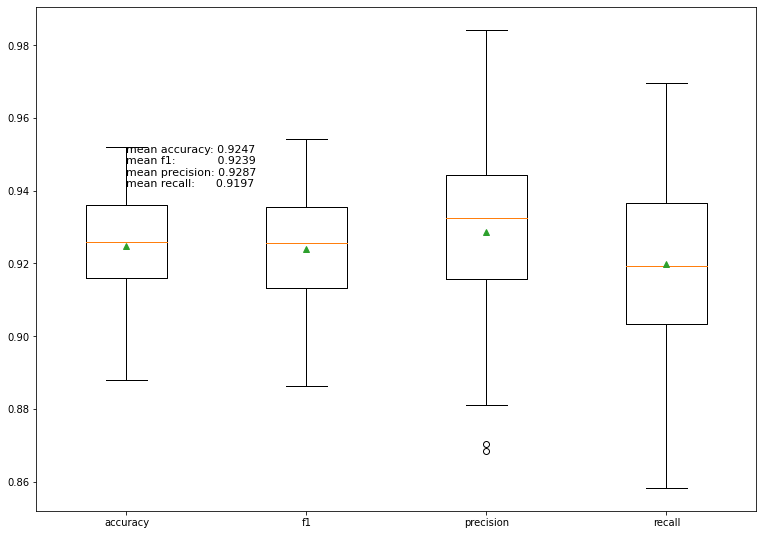

  0%|          | 0/100 [00:00<?, ?it/s]


56 SITES:



100%|██████████| 100/100 [02:25<00:00,  1.46s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.913736  0.927640     0.941544
1         f1     0.912259  0.926985     0.941712
2  precision     0.909453  0.929832     0.950210
3     recall     0.903925  0.924599     0.945273


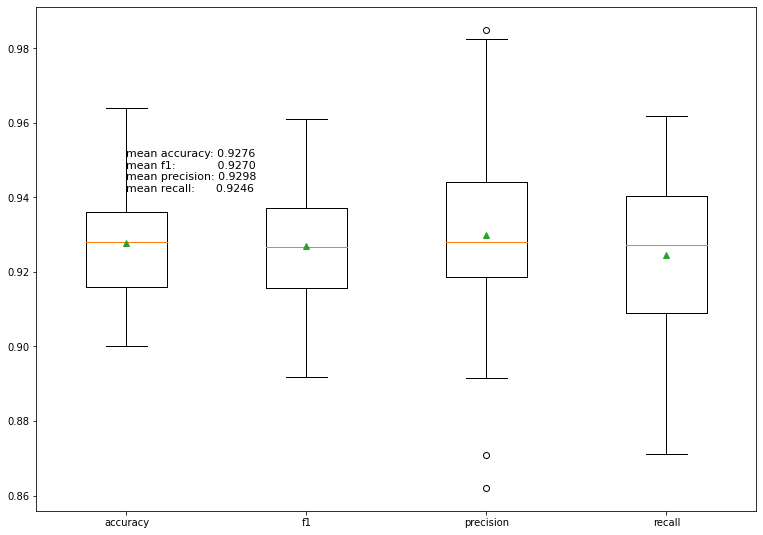

  0%|          | 0/100 [00:00<?, ?it/s]


57 SITES:



100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911574  0.926680     0.941786
1         f1     0.910853  0.925951     0.941048
2  precision     0.911003  0.929644     0.948284
3     recall     0.898022  0.922846     0.947670


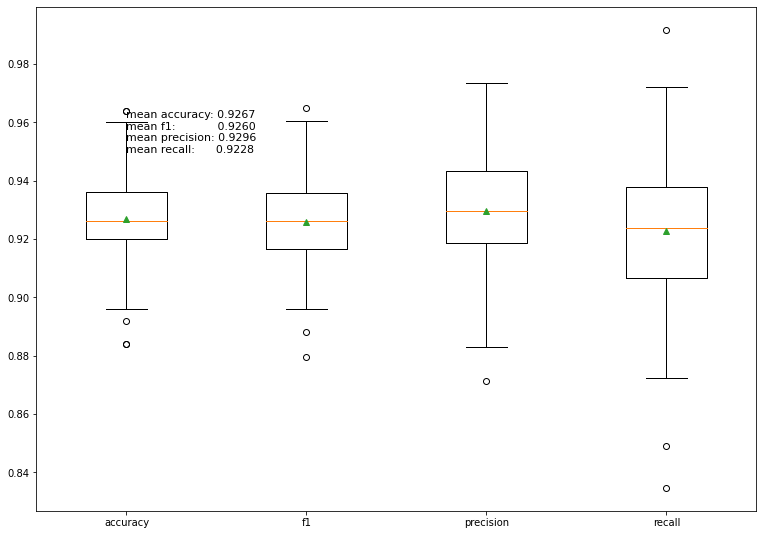

  0%|          | 0/100 [00:00<?, ?it/s]


58 SITES:



100%|██████████| 100/100 [02:30<00:00,  1.51s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912651  0.925040     0.937429
1         f1     0.910884  0.924155     0.937425
2  precision     0.907248  0.928372     0.949496
3     recall     0.898587  0.920600     0.942613


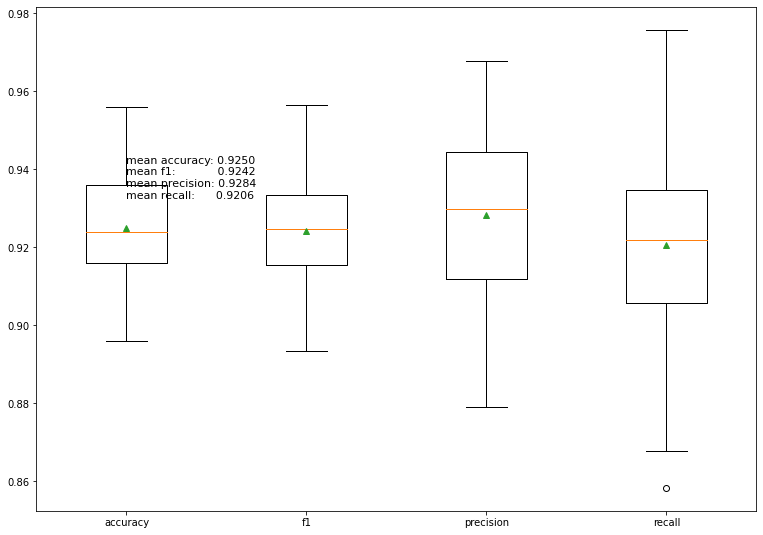

  0%|          | 0/100 [00:00<?, ?it/s]


59 SITES:



100%|██████████| 100/100 [02:32<00:00,  1.53s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914722  0.929680     0.944638
1         f1     0.913232  0.928583     0.943934
2  precision     0.915889  0.934138     0.952386
3     recall     0.899734  0.923557     0.947381


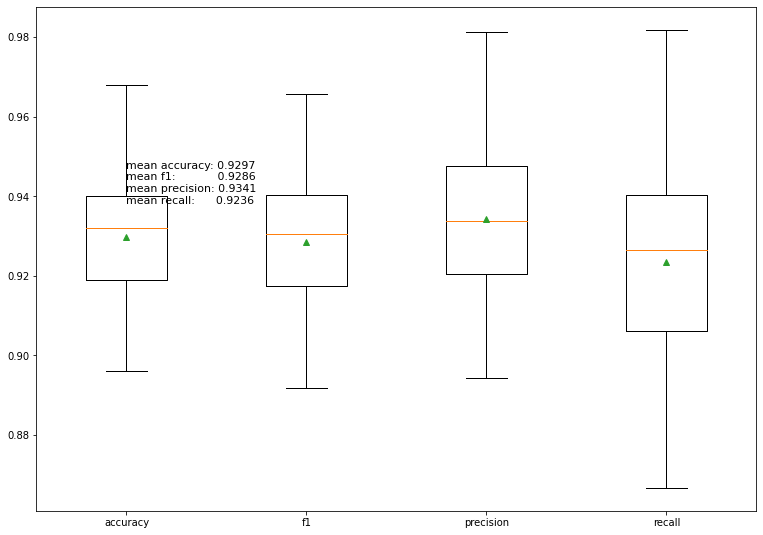

  0%|          | 0/100 [00:00<?, ?it/s]


60 SITES:



100%|██████████| 100/100 [02:38<00:00,  1.58s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912832  0.927240     0.941648
1         f1     0.911217  0.926731     0.942246
2  precision     0.910741  0.930269     0.949797
3     recall     0.899101  0.923767     0.948434


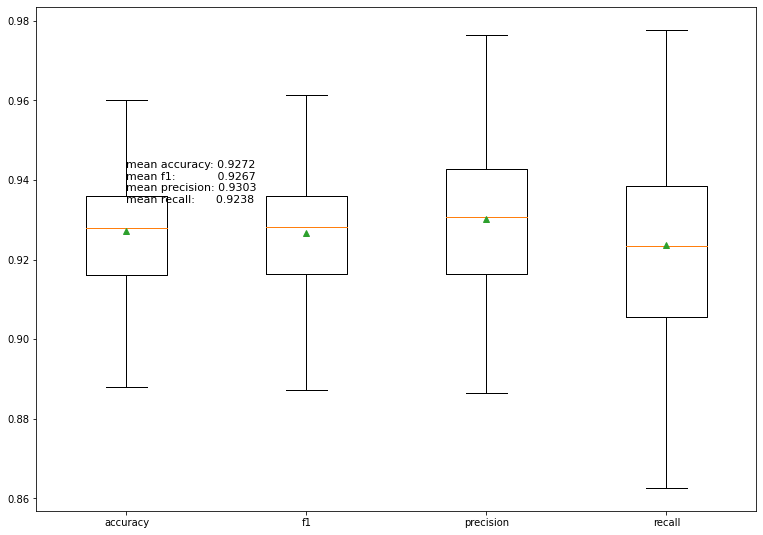

  0%|          | 0/100 [00:00<?, ?it/s]


61 SITES:



100%|██████████| 100/100 [02:44<00:00,  1.64s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.909415  0.924960     0.940505
1         f1     0.908283  0.923822     0.939362
2  precision     0.909439  0.929745     0.950051
3     recall     0.896327  0.918427     0.940528


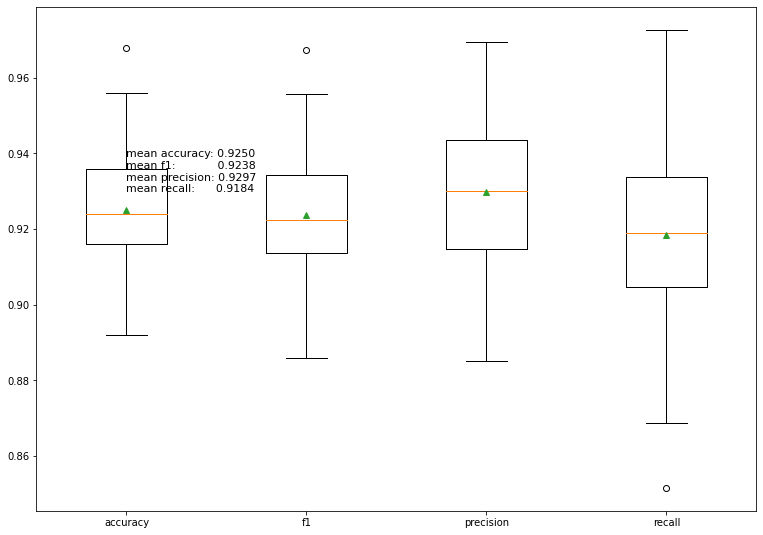

  0%|          | 0/100 [00:00<?, ?it/s]


62 SITES:



100%|██████████| 100/100 [02:42<00:00,  1.62s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912405  0.929120     0.945835
1         f1     0.911524  0.928732     0.945939
2  precision     0.908331  0.931446     0.954561
3     recall     0.902165  0.926624     0.951084


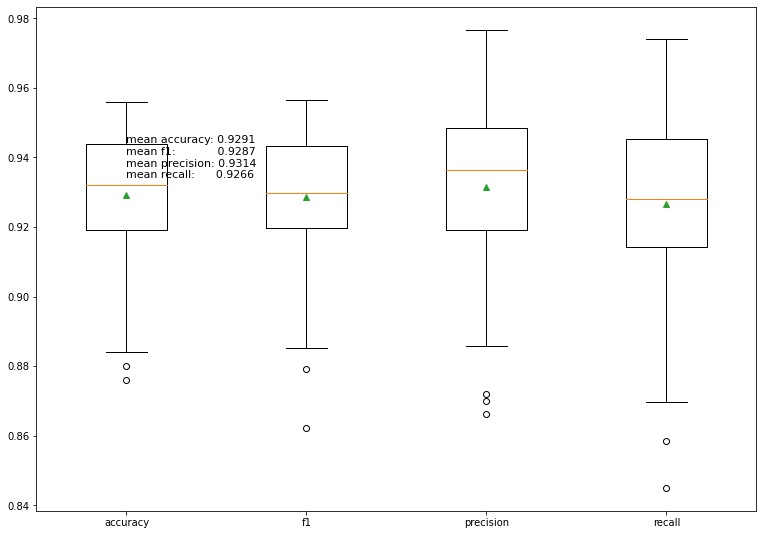

  0%|          | 0/100 [00:00<?, ?it/s]


63 SITES:



100%|██████████| 100/100 [02:42<00:00,  1.63s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914449  0.929320     0.944191
1         f1     0.913332  0.928484     0.943636
2  precision     0.914251  0.934754     0.955257
3     recall     0.896204  0.923035     0.949866


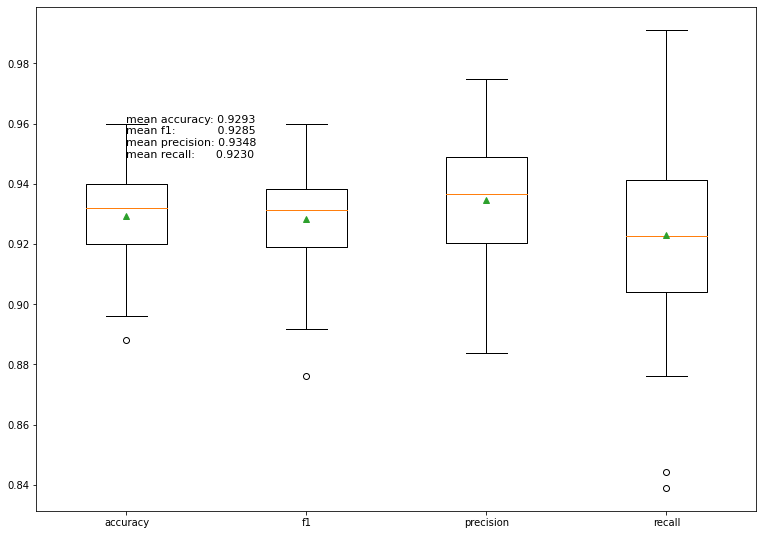

  0%|          | 0/100 [00:00<?, ?it/s]


64 SITES:



100%|██████████| 100/100 [02:49<00:00,  1.69s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912056  0.927320     0.942584
1         f1     0.910835  0.926887     0.942938
2  precision     0.908948  0.929013     0.949078
3     recall     0.901179  0.925276     0.949373


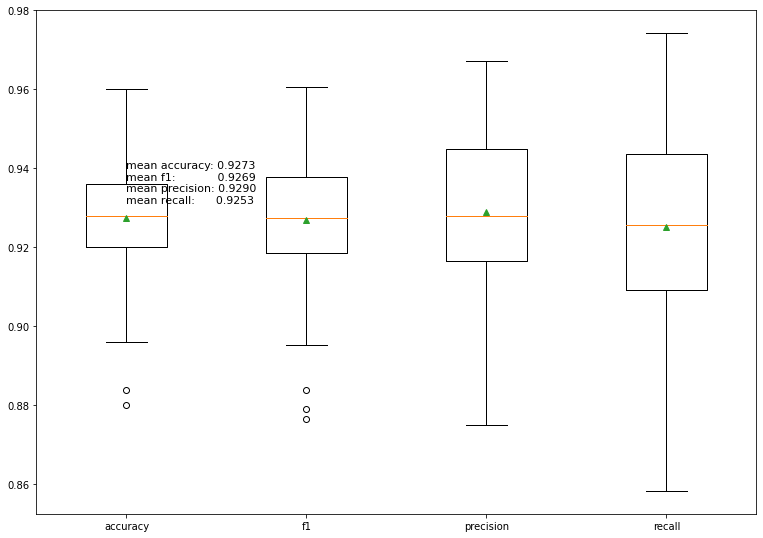

  0%|          | 0/100 [00:00<?, ?it/s]


65 SITES:



100%|██████████| 100/100 [02:52<00:00,  1.72s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.913449  0.928080     0.942711
1         f1     0.912680  0.926877     0.941075
2  precision     0.908079  0.930081     0.952082
3     recall     0.903020  0.924271     0.945521


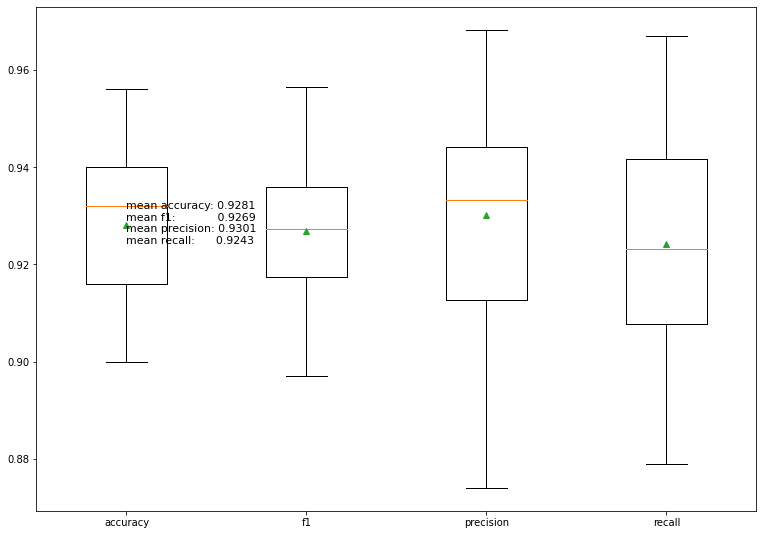

  0%|          | 0/100 [00:00<?, ?it/s]


66 SITES:



100%|██████████| 100/100 [04:57<00:00,  2.98s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916009  0.929040     0.942071
1         f1     0.914148  0.928184     0.942220
2  precision     0.910439  0.930692     0.950945
3     recall     0.903940  0.926251     0.948561


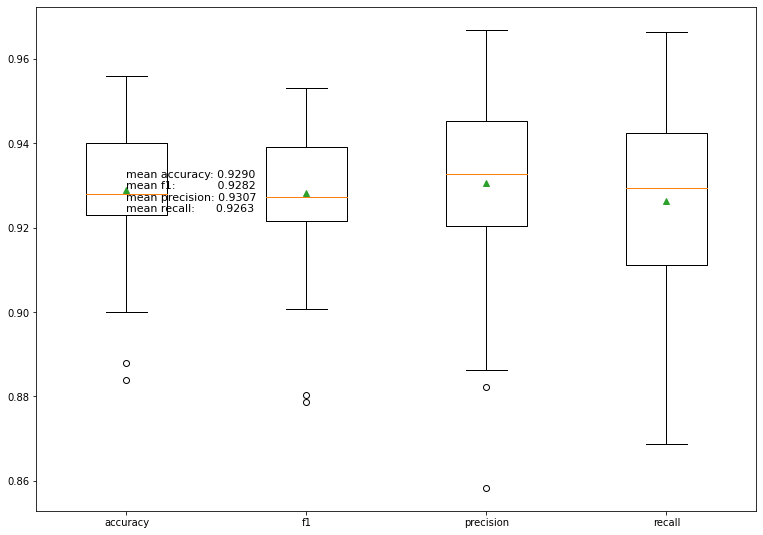

  0%|          | 0/100 [00:00<?, ?it/s]


67 SITES:



100%|██████████| 100/100 [02:57<00:00,  1.78s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915590  0.929120     0.942650
1         f1     0.914628  0.928476     0.942324
2  precision     0.909635  0.931227     0.952819
3     recall     0.905587  0.926293     0.946999


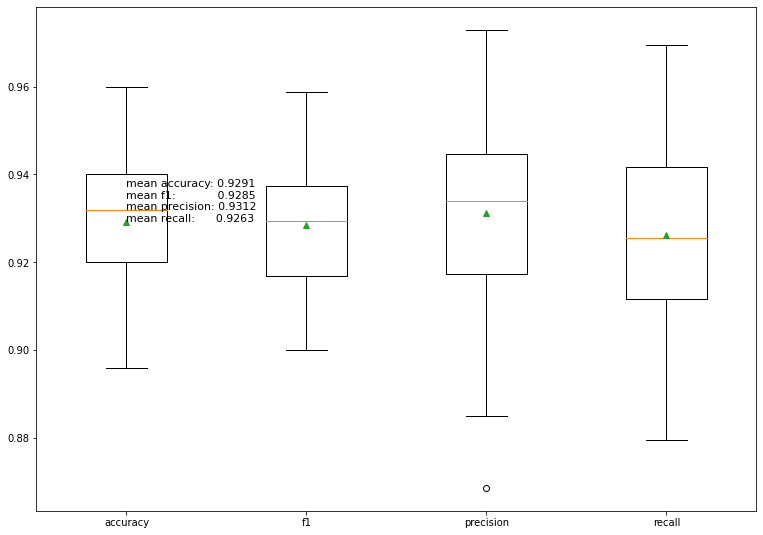

  0%|          | 0/100 [00:00<?, ?it/s]


68 SITES:



100%|██████████| 100/100 [02:56<00:00,  1.77s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.917813  0.930920     0.944027
1         f1     0.916476  0.929998     0.943520
2  precision     0.913177  0.932448     0.951719
3     recall     0.906648  0.928067     0.949486


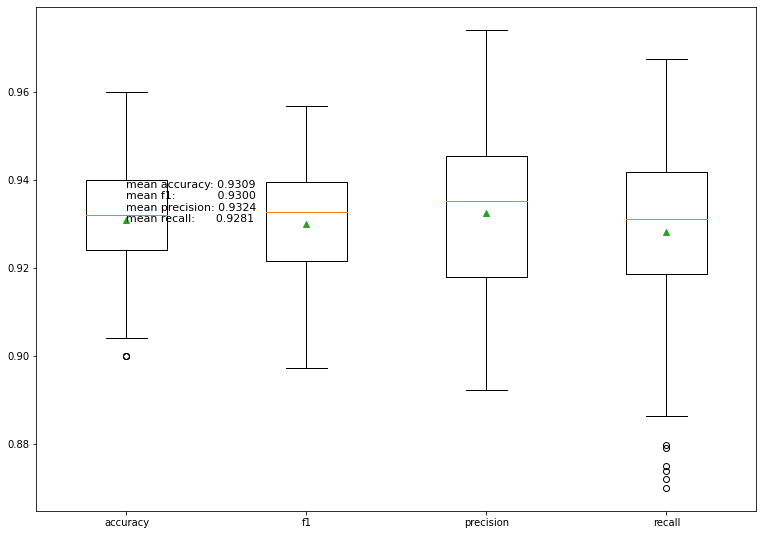

  0%|          | 0/100 [00:00<?, ?it/s]


69 SITES:



100%|██████████| 100/100 [02:59<00:00,  1.79s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912758  0.926760     0.940762
1         f1     0.913118  0.926931     0.940743
2  precision     0.907744  0.927399     0.947054
3     recall     0.906424  0.926923     0.947422


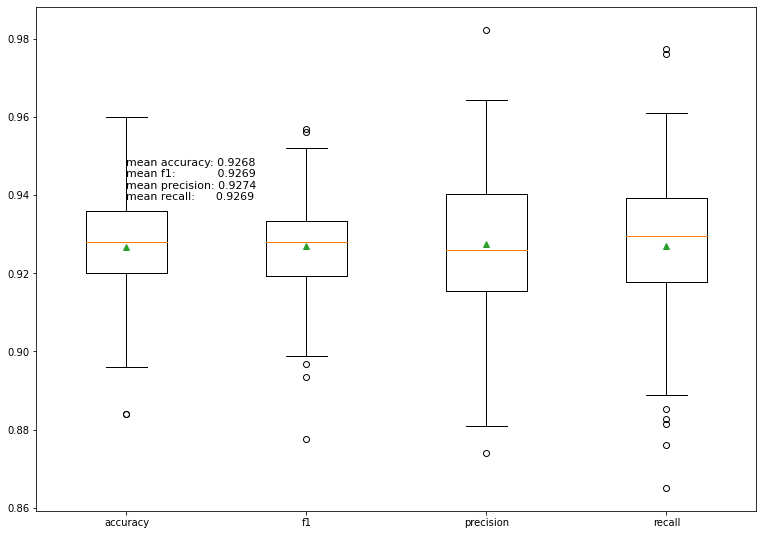

  0%|          | 0/100 [00:00<?, ?it/s]


70 SITES:



100%|██████████| 100/100 [03:00<00:00,  1.81s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.913719  0.927320     0.940921
1         f1     0.912967  0.927050     0.941132
2  precision     0.905109  0.927823     0.950538
3     recall     0.907044  0.926832     0.946621


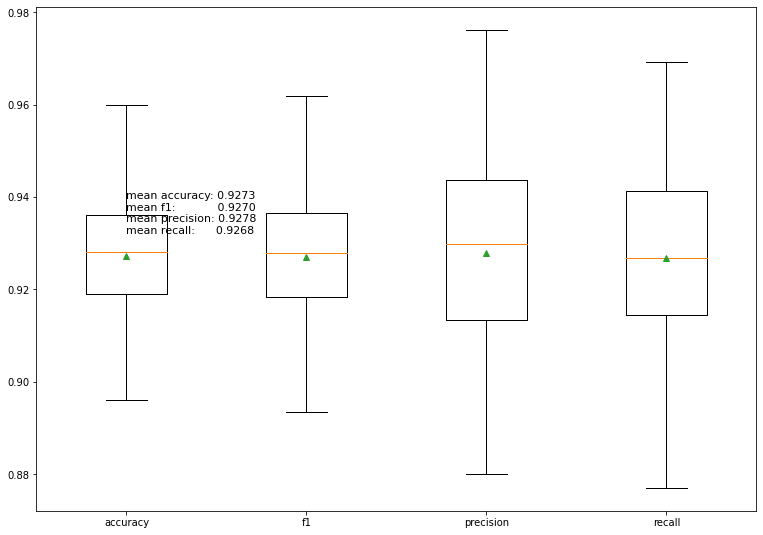

  0%|          | 0/100 [00:00<?, ?it/s]


71 SITES:



100%|██████████| 100/100 [03:01<00:00,  1.81s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914224  0.928680     0.943136
1         f1     0.913936  0.928489     0.943043
2  precision     0.908536  0.928674     0.948812
3     recall     0.906224  0.928838     0.951453


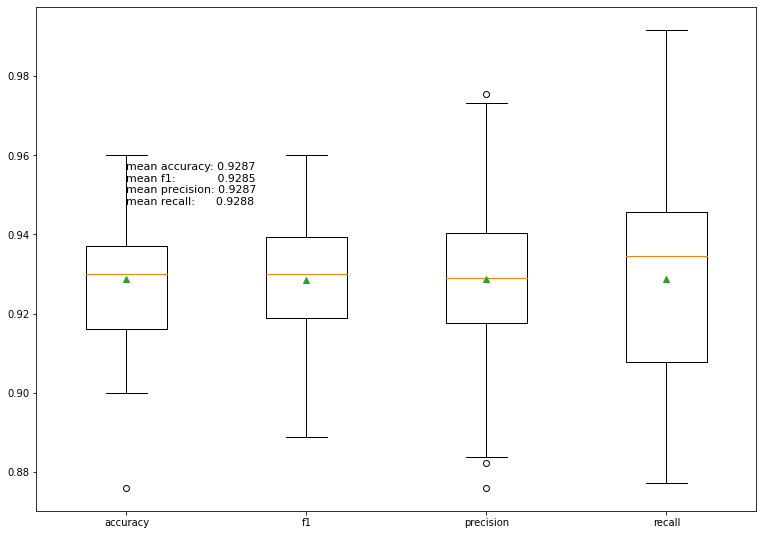

  0%|          | 0/100 [00:00<?, ?it/s]


72 SITES:



100%|██████████| 100/100 [03:06<00:00,  1.87s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914722  0.929680     0.944638
1         f1     0.914876  0.929975     0.945075
2  precision     0.909177  0.929883     0.950589
3     recall     0.907915  0.930597     0.953278


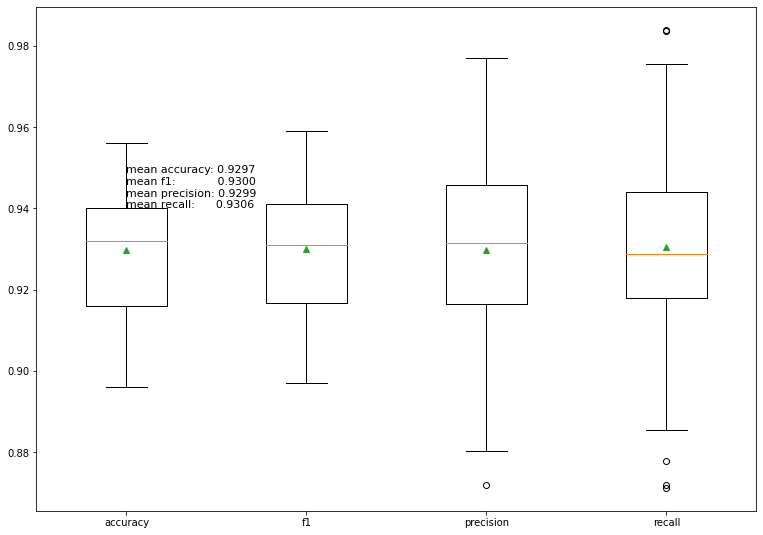

  0%|          | 0/100 [00:00<?, ?it/s]


73 SITES:



100%|██████████| 100/100 [03:05<00:00,  1.85s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914254  0.928640     0.943026
1         f1     0.912997  0.928234     0.943471
2  precision     0.908466  0.931745     0.955024
3     recall     0.904184  0.925318     0.946452


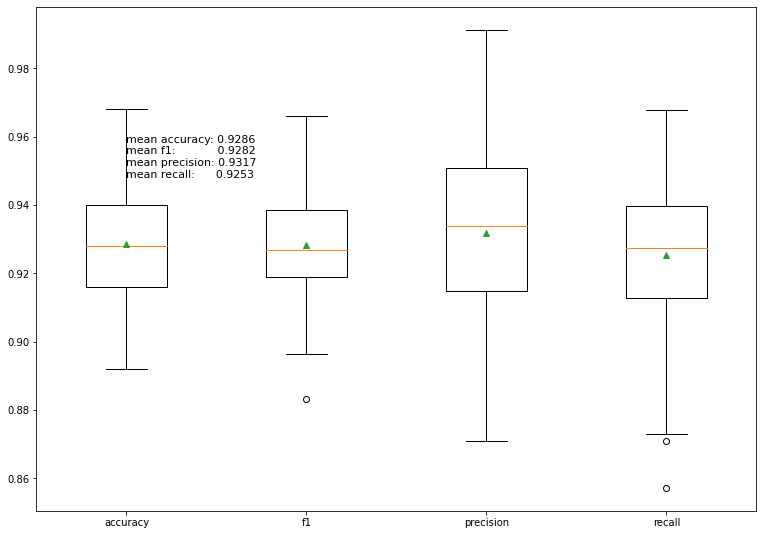

  0%|          | 0/100 [00:00<?, ?it/s]


74 SITES:



100%|██████████| 100/100 [03:07<00:00,  1.87s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914972  0.928360     0.941748
1         f1     0.913923  0.927955     0.941986
2  precision     0.910572  0.928422     0.946272
3     recall     0.904742  0.927991     0.951240


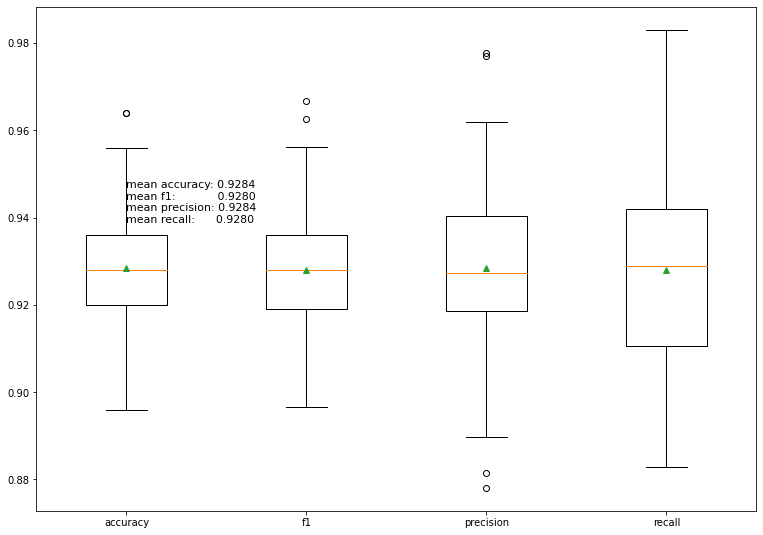

  0%|          | 0/100 [00:00<?, ?it/s]


75 SITES:



100%|██████████| 100/100 [03:08<00:00,  1.89s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.917484  0.930000     0.942516
1         f1     0.916969  0.930204     0.943438
2  precision     0.909866  0.930142     0.950419
3     recall     0.910589  0.930770     0.950951


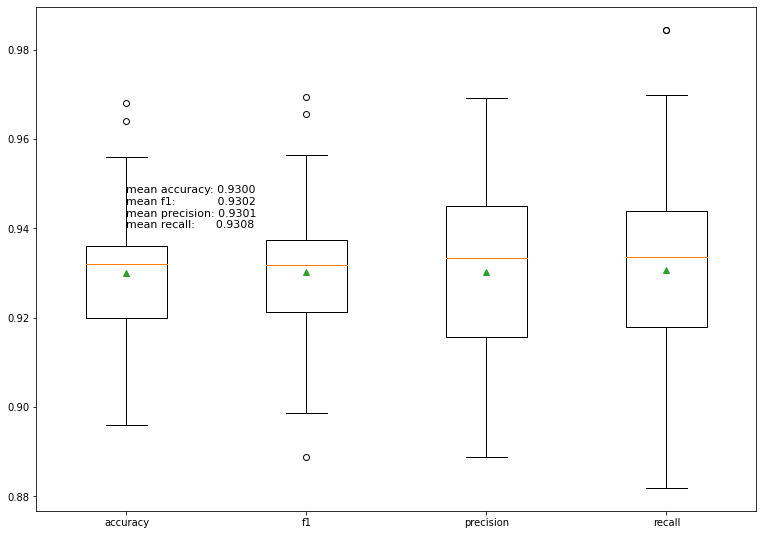

  0%|          | 0/100 [00:00<?, ?it/s]


76 SITES:



100%|██████████| 100/100 [03:11<00:00,  1.92s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911426  0.926160     0.940894
1         f1     0.910788  0.926073     0.941357
2  precision     0.905085  0.927553     0.950020
3     recall     0.902554  0.925192     0.947830


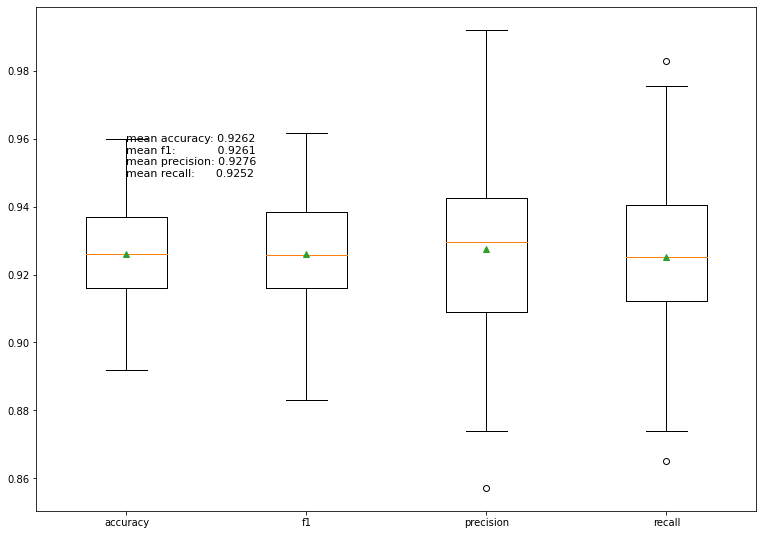

  0%|          | 0/100 [00:00<?, ?it/s]


77 SITES:



100%|██████████| 100/100 [03:20<00:00,  2.01s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915916  0.930720     0.945524
1         f1     0.915442  0.930191     0.944941
2  precision     0.907897  0.927673     0.947449
3     recall     0.910570  0.933231     0.955893


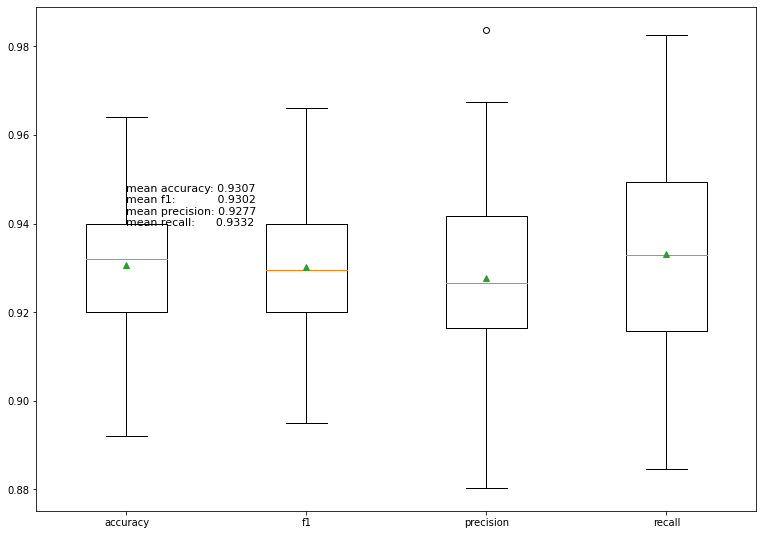

  0%|          | 0/100 [00:00<?, ?it/s]


78 SITES:



100%|██████████| 100/100 [03:25<00:00,  2.06s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.918276  0.930560     0.942844
1         f1     0.916834  0.929995     0.943156
2  precision     0.910448  0.930433     0.950417
3     recall     0.909541  0.930073     0.950605


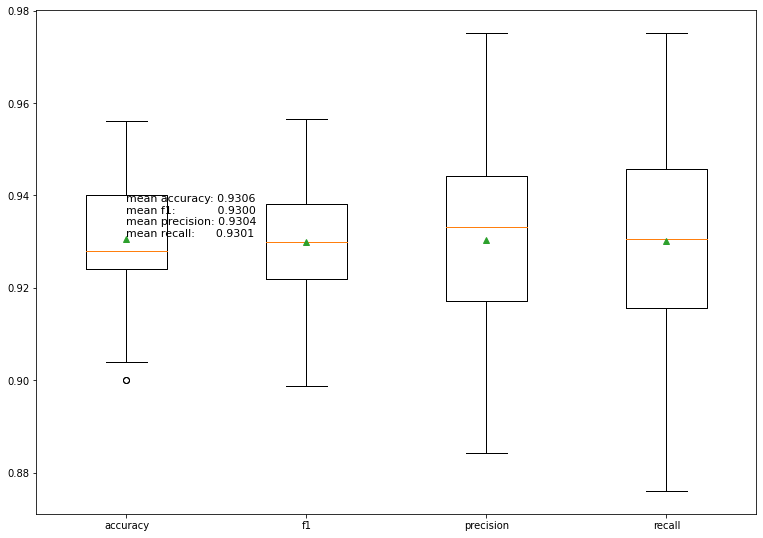

  0%|          | 0/100 [00:00<?, ?it/s]


79 SITES:



100%|██████████| 100/100 [03:33<00:00,  2.13s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915281  0.930240     0.945199
1         f1     0.914331  0.929993     0.945655
2  precision     0.912535  0.932953     0.953371
3     recall     0.905766  0.927477     0.949188


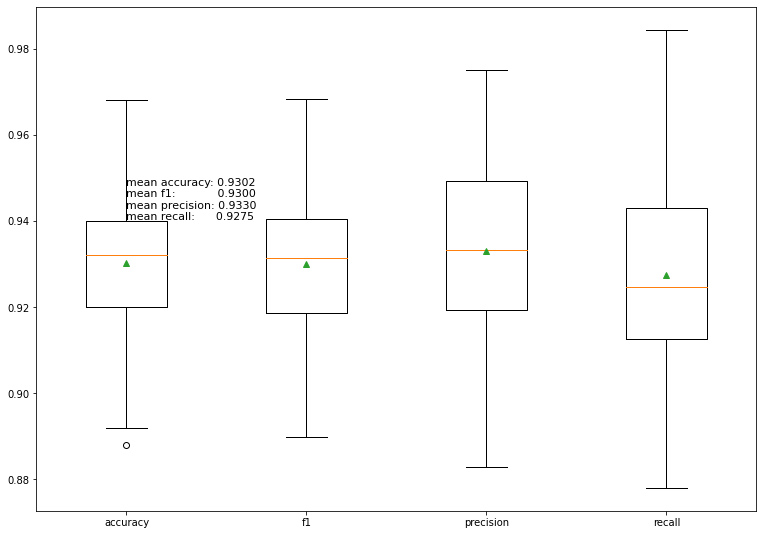

  0%|          | 0/100 [00:00<?, ?it/s]


80 SITES:



100%|██████████| 100/100 [03:33<00:00,  2.14s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915319  0.929480     0.943641
1         f1     0.914709  0.929230     0.943751
2  precision     0.914405  0.935242     0.956079
3     recall     0.900497  0.923897     0.947298


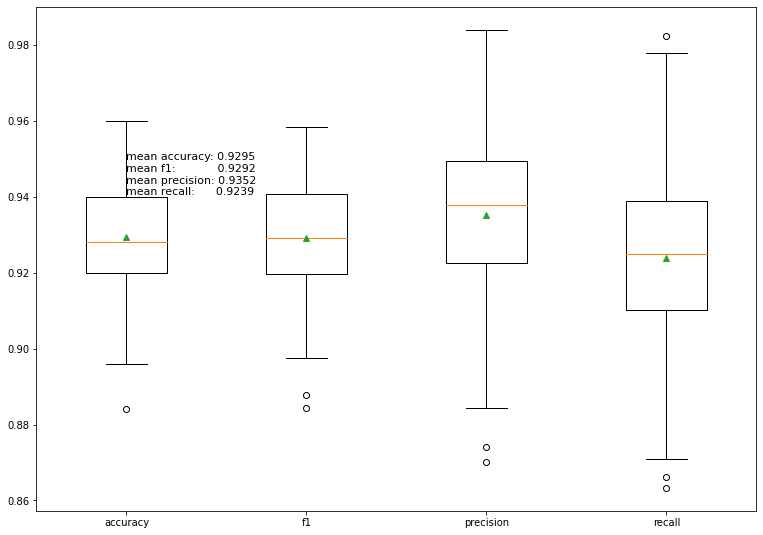

  0%|          | 0/100 [00:00<?, ?it/s]


81 SITES:



100%|██████████| 100/100 [03:36<00:00,  2.17s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.913651  0.929560     0.945469
1         f1     0.913415  0.929833     0.946252
2  precision     0.912547  0.933190     0.953834
3     recall     0.902363  0.927037     0.951711


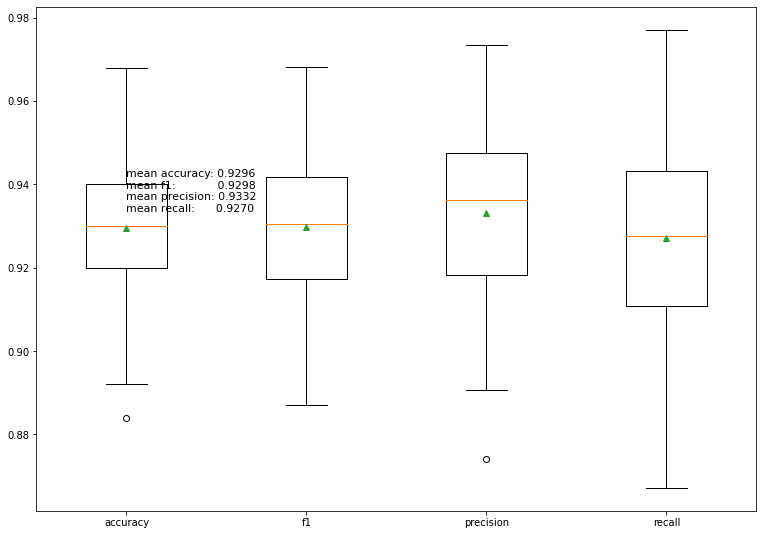

  0%|          | 0/100 [00:00<?, ?it/s]


82 SITES:



100%|██████████| 100/100 [03:37<00:00,  2.18s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916536  0.932600     0.948664
1         f1     0.915344  0.932086     0.948829
2  precision     0.909495  0.931387     0.953279
3     recall     0.909111  0.933339     0.957566


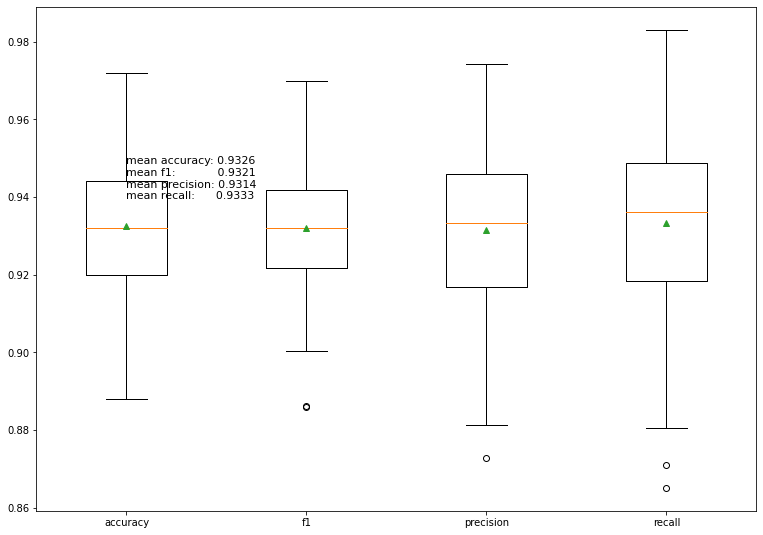

  0%|          | 0/100 [00:00<?, ?it/s]


83 SITES:



100%|██████████| 100/100 [03:39<00:00,  2.19s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914864  0.929560     0.944256
1         f1     0.913799  0.929295     0.944791
2  precision     0.908616  0.930513     0.952410
3     recall     0.903886  0.928747     0.953608


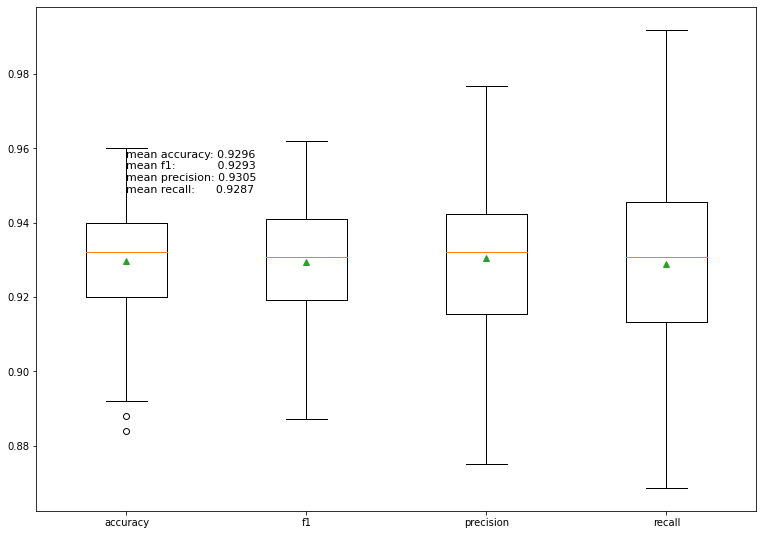

  0%|          | 0/100 [00:00<?, ?it/s]


84 SITES:



100%|██████████| 100/100 [03:41<00:00,  2.22s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915219  0.930200     0.945181
1         f1     0.913780  0.929574     0.945367
2  precision     0.908301  0.930315     0.952330
3     recall     0.905353  0.929459     0.953566


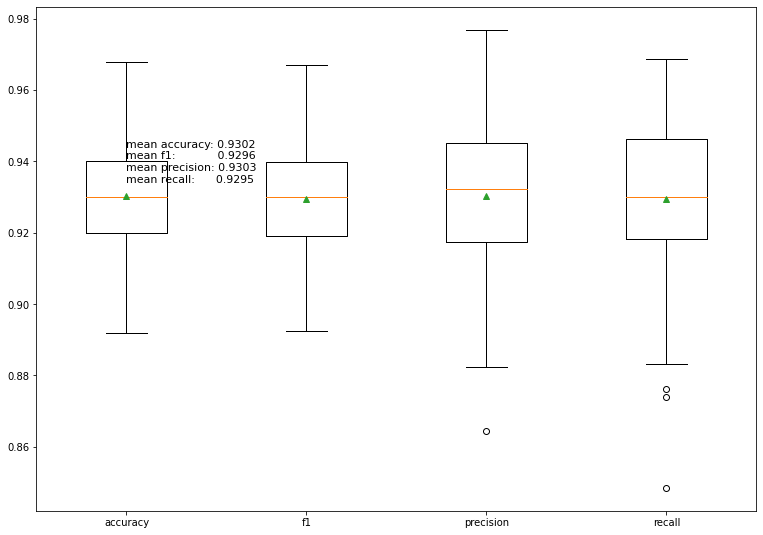

  0%|          | 0/100 [00:00<?, ?it/s]


85 SITES:



100%|██████████| 100/100 [03:47<00:00,  2.28s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916556  0.929840     0.943124
1         f1     0.916148  0.929419     0.942689
2  precision     0.913188  0.932631     0.952074
3     recall     0.906283  0.926702     0.947120


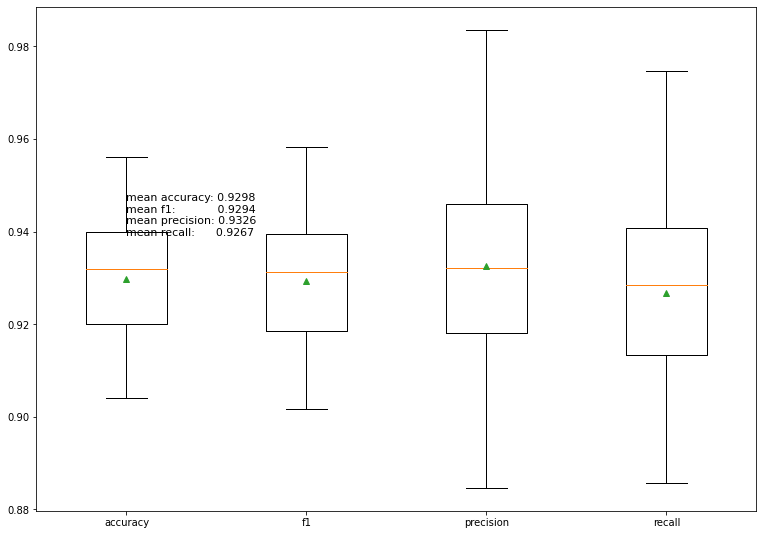

  0%|          | 0/100 [00:00<?, ?it/s]


86 SITES:



100%|██████████| 100/100 [03:49<00:00,  2.30s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915261  0.929640     0.944019
1         f1     0.914298  0.929210     0.944123
2  precision     0.910035  0.930947     0.951860
3     recall     0.905269  0.928028     0.950786


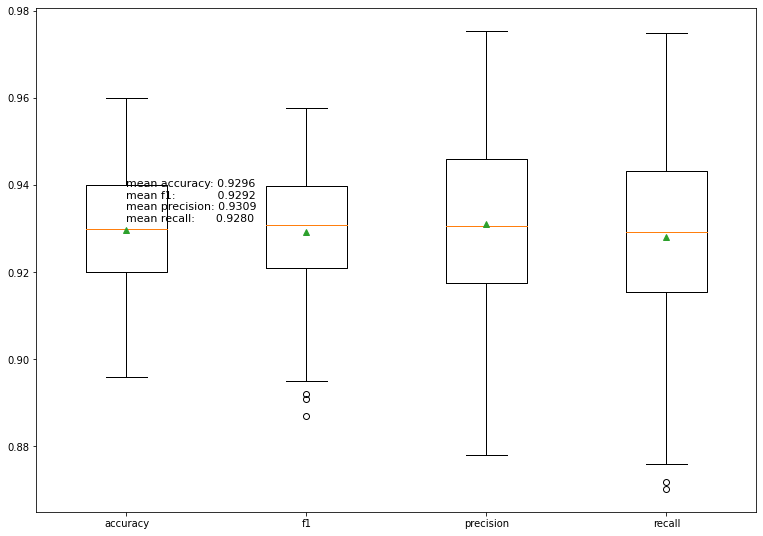

  0%|          | 0/100 [00:00<?, ?it/s]


87 SITES:



100%|██████████| 100/100 [06:02<00:00,  3.63s/it]


      metric  lower_bound      mean  upper_bound
0   accuracy     0.914177  0.928880     0.943583
1         f1     0.913804  0.928858     0.943913
2  precision     0.910468  0.932450     0.954432
3     recall     0.902884  0.925900     0.948916


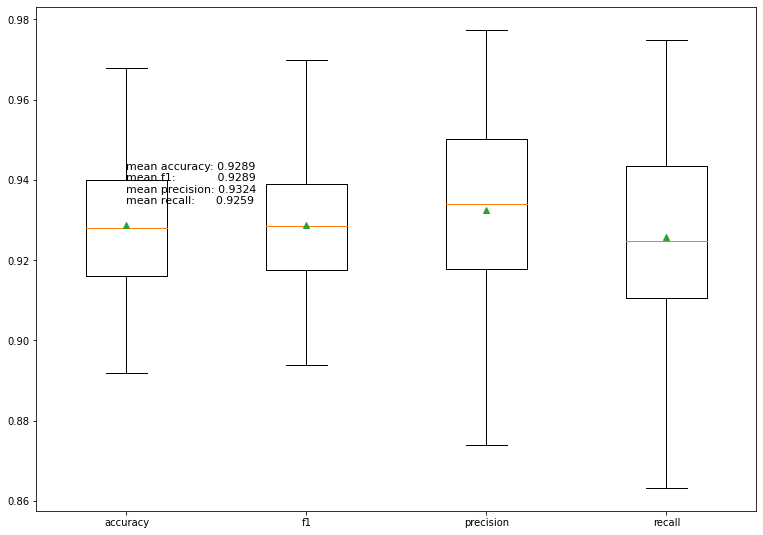

  0%|          | 0/100 [00:00<?, ?it/s]


88 SITES:



100%|██████████| 100/100 [03:55<00:00,  2.35s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.918373  0.931800     0.945227
1         f1     0.916530  0.930914     0.945299
2  precision     0.914005  0.933499     0.952993
3     recall     0.905462  0.928904     0.952346


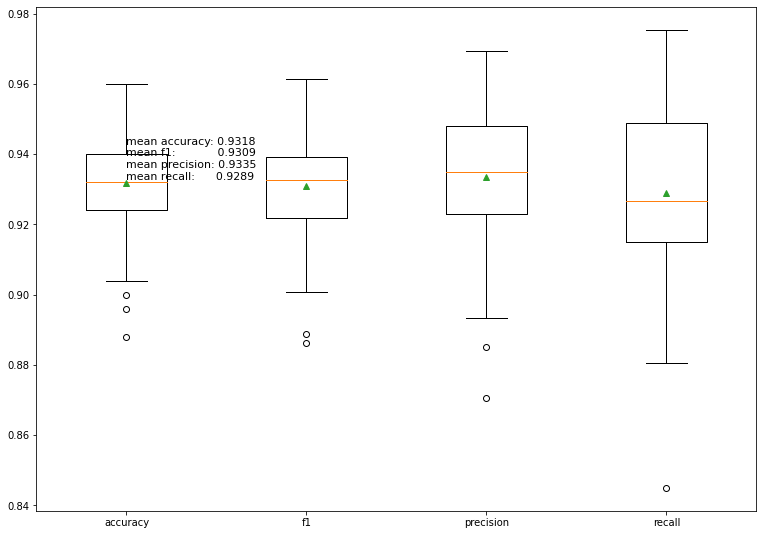

  0%|          | 0/100 [00:00<?, ?it/s]


89 SITES:



100%|██████████| 100/100 [03:50<00:00,  2.30s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.912073  0.929080     0.946087
1         f1     0.910970  0.928336     0.945701
2  precision     0.911246  0.932545     0.953844
3     recall     0.897811  0.924793     0.951775


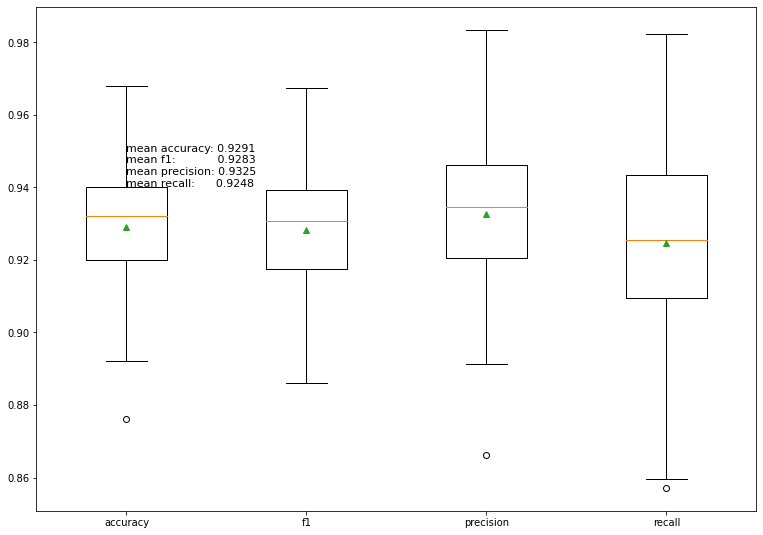

  0%|          | 0/100 [00:00<?, ?it/s]


90 SITES:



100%|██████████| 100/100 [03:54<00:00,  2.34s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916791  0.930920     0.945049
1         f1     0.916910  0.930931     0.944951
2  precision     0.912973  0.932523     0.952074
3     recall     0.905408  0.929990     0.954572


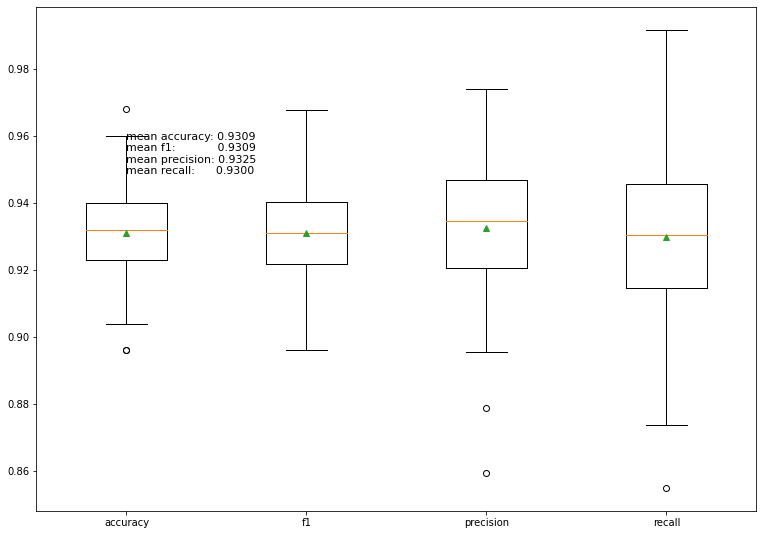

  0%|          | 0/100 [00:00<?, ?it/s]


91 SITES:



100%|██████████| 100/100 [03:57<00:00,  2.37s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.911001  0.926480     0.941959
1         f1     0.909293  0.925858     0.942422
2  precision     0.907533  0.927636     0.947739
3     recall     0.897393  0.924743     0.952092


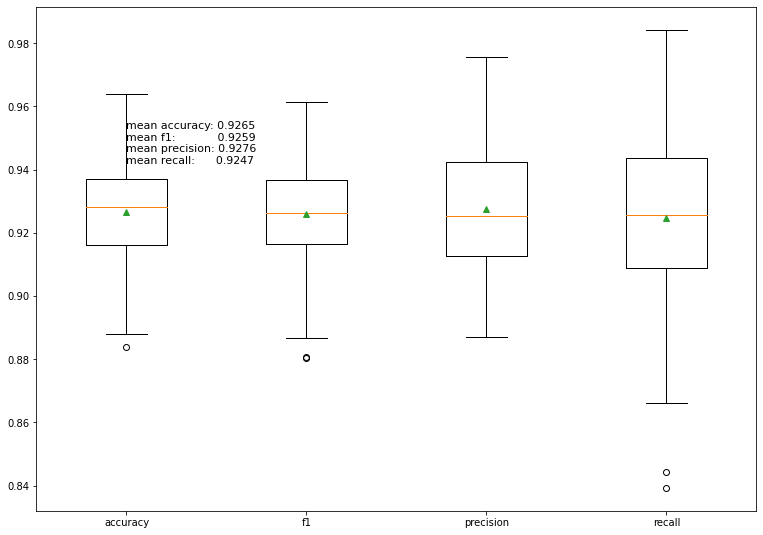

  0%|          | 0/100 [00:00<?, ?it/s]


92 SITES:



100%|██████████| 100/100 [04:01<00:00,  2.41s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.915327  0.929920     0.944513
1         f1     0.914147  0.929298     0.944448
2  precision     0.902931  0.926237     0.949543
3     recall     0.911547  0.932971     0.954396


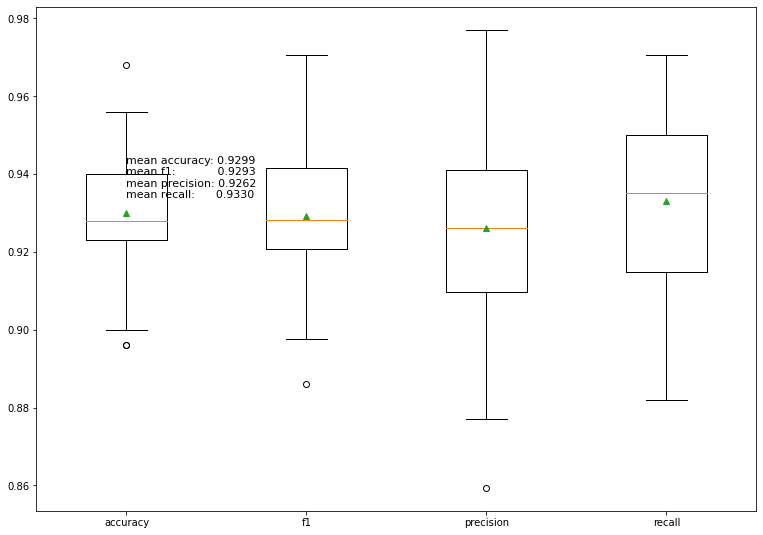

  0%|          | 0/100 [00:00<?, ?it/s]


93 SITES:



100%|██████████| 100/100 [03:58<00:00,  2.38s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.916144  0.929960     0.943776
1         f1     0.914859  0.929325     0.943791
2  precision     0.908864  0.930304     0.951744
3     recall     0.908908  0.928820     0.948732


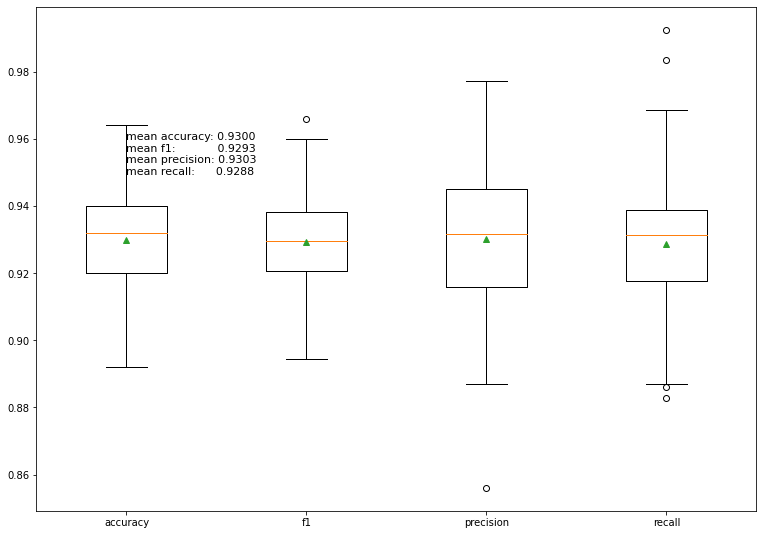

  0%|          | 0/100 [00:00<?, ?it/s]


94 SITES:



100%|██████████| 100/100 [04:08<00:00,  2.49s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914780  0.929640     0.944500
1         f1     0.913479  0.928850     0.944221
2  precision     0.908533  0.930248     0.951963
3     recall     0.904155  0.928073     0.951991


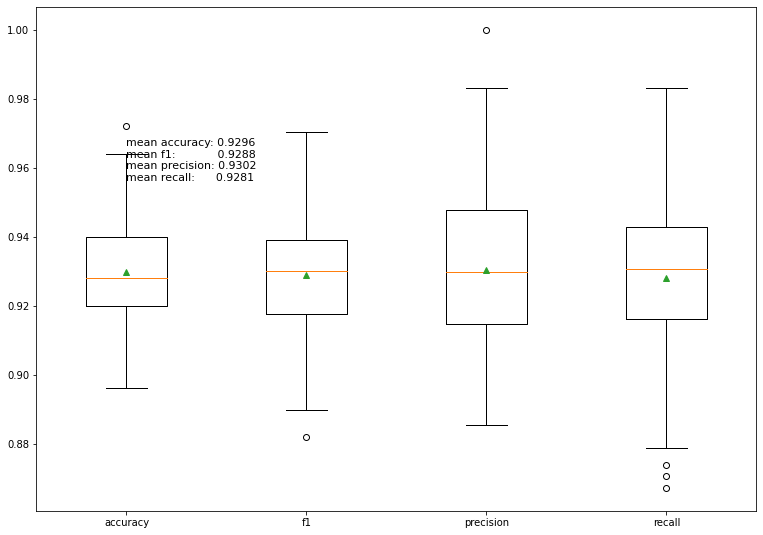

  0%|          | 0/100 [00:00<?, ?it/s]


95 SITES:



100%|██████████| 100/100 [04:15<00:00,  2.55s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.914075  0.928840     0.943605
1         f1     0.913541  0.928808     0.944075
2  precision     0.905656  0.928560     0.951465
3     recall     0.904924  0.929791     0.954657


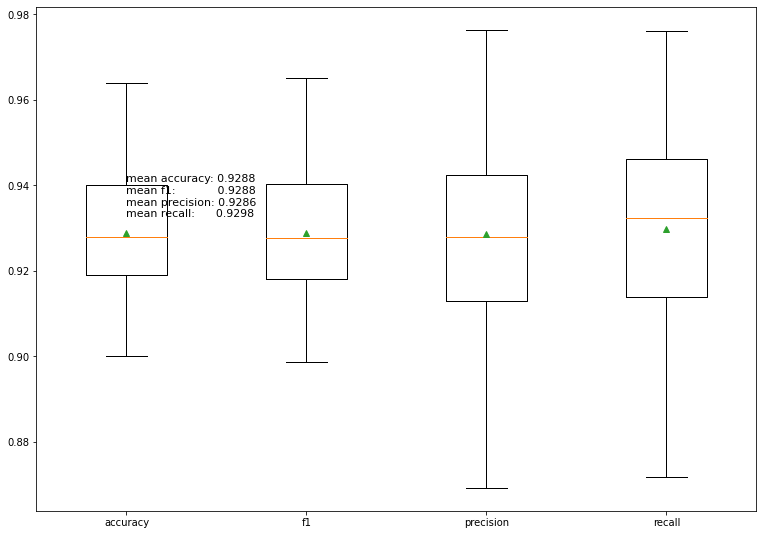

  0%|          | 0/100 [00:00<?, ?it/s]


96 SITES:



100%|██████████| 100/100 [04:07<00:00,  2.47s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.917730  0.931200     0.944670
1         f1     0.916711  0.930541     0.944370
2  precision     0.910078  0.931211     0.952345
3     recall     0.908997  0.930432     0.951866


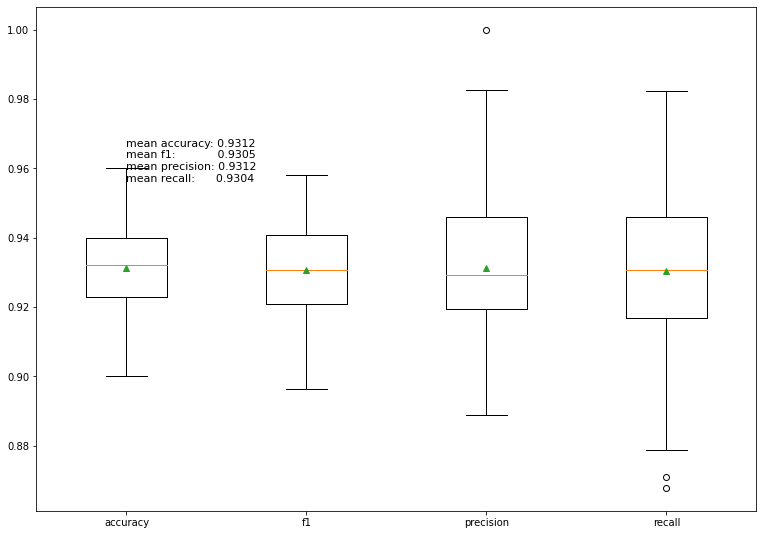

  0%|          | 0/100 [00:00<?, ?it/s]


97 SITES:



100%|██████████| 100/100 [04:08<00:00,  2.48s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.917092  0.930880     0.944668
1         f1     0.916197  0.930519     0.944841
2  precision     0.912002  0.931508     0.951014
3     recall     0.907255  0.930065     0.952875


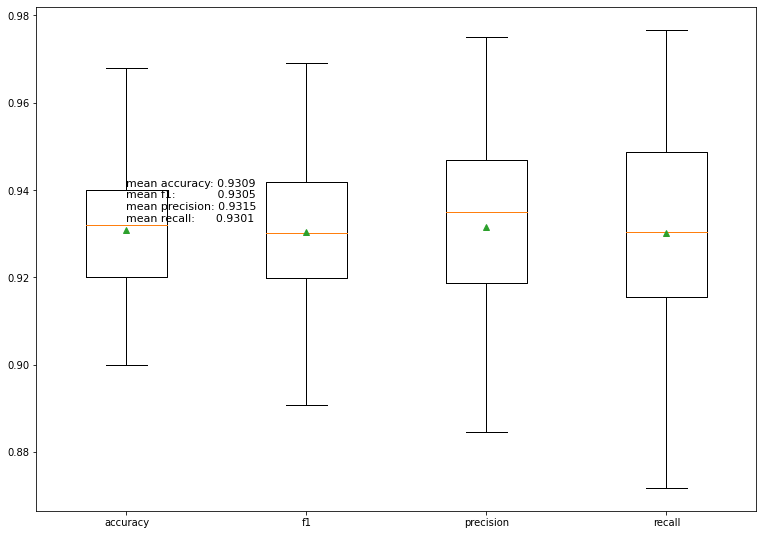

  0%|          | 0/100 [00:00<?, ?it/s]


98 SITES:



100%|██████████| 100/100 [04:10<00:00,  2.50s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.917123  0.932800     0.948477
1         f1     0.917019  0.932780     0.948542
2  precision     0.914073  0.933172     0.952270
3     recall     0.909098  0.932856     0.956614


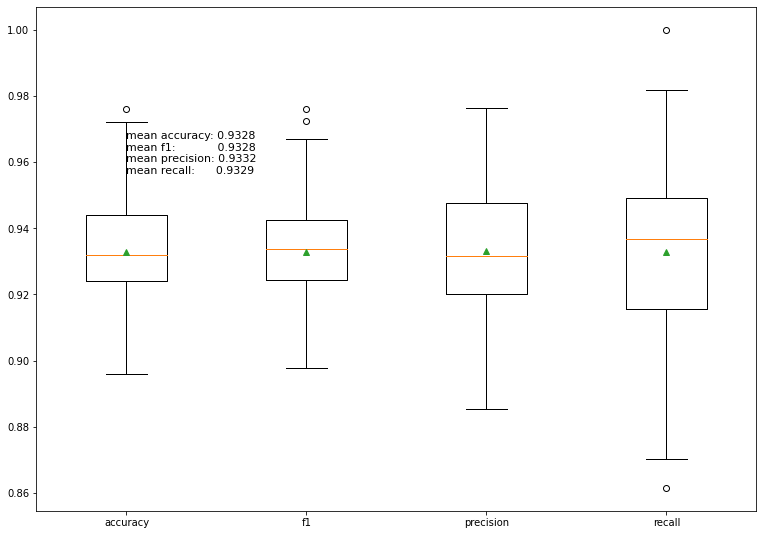

  0%|          | 0/100 [00:00<?, ?it/s]


99 SITES:



100%|██████████| 100/100 [04:09<00:00,  2.50s/it]

      metric  lower_bound      mean  upper_bound
0   accuracy     0.918782  0.932000     0.945218
1         f1     0.917805  0.931758     0.945710
2  precision     0.913743  0.931349     0.948954
3     recall     0.911194  0.932575     0.953956


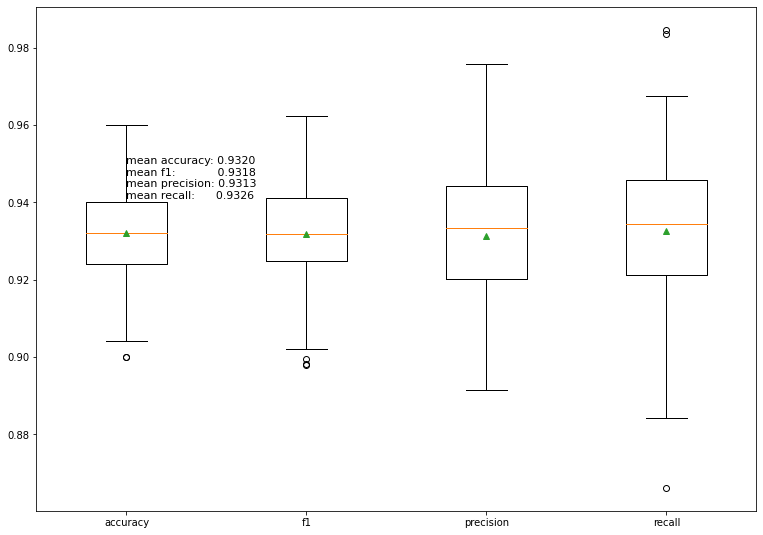

In [22]:
import sys
sys.path.insert(1,r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\analyses v2')
from analysis_functions import *
import numpy as np

# Analyze
# print('ONE MODEL EXAMPLE:')
# model, _, X_test, _, y_test, _, vocab = train_logistic_regression(df, 'meta tokenized', meta_name=False)
# accuracy, f1, precision, recall = evaluate_logistic_regression(model, X_test, y_test, vocab, PRINT=True)

accuracy_mean = []
f1_mean = []
precision_mean = []
recall_mean = []

for i in range(1,num_sites_to_check):
    tok_col_name = 'meta_tokenized_' + str(i)
    print('\n{} SITES:\n'.format(i))
    results = confidence_interval_logistic_regression(100, df, col=tok_col_name)
    accuracy_mean.append(np.mean(results[0,:]))
    f1_mean.append(np.mean(results[1,:]))
    precision_mean.append(np.mean(results[2,:]))
    recall_mean.append(np.mean(results[3,:]))

In [23]:
import pickle

with open('accuracy_mean.pkl', 'wb') as f:
    pickle.dump(accuracy_mean, f)
f.close()
with open('f1_mean.pkl', 'wb') as f:
    pickle.dump(f1_mean, f)
f.close()
with open('precision_mean.pkl', 'wb') as f:
    pickle.dump(precision_mean, f)
f.close()
with open('recall_mean.pkl', 'wb') as f:
    pickle.dump(recall_mean, f)
f.close()

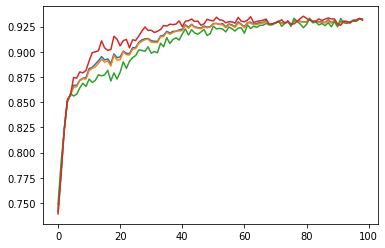

In [27]:
import matplotlib.pyplot as plt

plt.plot(accuracy_mean)
plt.plot(f1_mean)
plt.plot(recall_mean)
plt.plot(precision_mean)

## Let's do the same thing but for content this time

In [1]:
from pathlib import Path
import pickle
import os
import pandas as pd

# Loop through the parsed text, fill in dataframe along the way
real_dir = r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\html_parsed\real_500' 
fake_dir = r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\html_parsed\fake_500'

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_real_list.pkl', 'rb') as f:
    real_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / '500_fake_list.pkl', 'rb') as f:
    fake_list = pickle.load(f)
f.close()

with open(Path.cwd().parent / 'content_analysis' / 'analyses v2' / 'html_df_tokenized.pkl', 'rb') as f:
    df = pickle.load(f)
f.close()



def filter_text(source_dir):
    '''
    Takes the meta tags present in all the .txt files at source dir and returns a list of tokens
    present in those txt files
    
    ~~~~ ARGUMENTS ~~~~
    - source_dir : path or str
        - directory containing .txt files of parsed text

    ~~~~ RETURNS ~~~~
    - concat : str
        - large string of concatenated text
    '''
    content = ''
    for text in [source_dir / x for x in os.listdir(source_dir)]:
        with open(text, 'r', encoding='utf8') as f:
            lines = f.readlines()
        f.close()
        
        page_content = ' '.join(lines)

        content = content + ' ' + page_content
            

    # Tokenize
    end_punc = ["'", '"', '!', '?', '.', ')']
    tokenized = tokenize.sent_tokenize(content)
    tokenized = list(set(tokenized))
    to_del = []
    for i in range(len(tokenized)):
        if tokenized[i][-1] not in end_punc:
            to_del.append(i)
    to_del.reverse()
    for d in to_del:
        tokenized.pop(d)
    concat = ' '.join(tokenized)

    return concat

df.head()

,index,site,label,y,text,tokenized
0,0,http://9to5mac.com,real,0,"In a memo that was leaked to the Verge , Cook ...","[memo, wa, leak, verg, cook, say, appl, “, eve..."
1,1,http://wfae.org,real,0,Charlotte Talks Local News Roundup: Housing...,"[charlott, talk, local, news, roundup, hous, f..."
2,2,http://climatefeedback.org,real,0,The workshop will then move to more concrete e...,"[workshop, move, concret, exampl, initi, tackl..."
3,3,http://wdbj7.com,real,0,Power Life by Tony Horton All Adult...,"[power, life, toni, horton, adult, due, larg, ..."
4,4,http://keyc.com,real,0,Good To Know This Recommended by ...,"[good, know, thi, recommend, recommend, high, ..."


In [2]:
from tqdm import tqdm

num_sites_to_check = 50

for i in tqdm(range(1,num_sites_to_check+1)):
    content_list = []
    for idx, row in df.iterrows():
        dir_ = Path.cwd().parent / 'content_analysis' / 'html_parsed' / (row.label + '_500') / str(row['index'])
        
        content = ''
        sites_added = 1
        for text in [dir_ / x for x in os.listdir(dir_)]:
            if sites_added > i:
                break
            else:
                sites_added += 1

            with open(text, 'r', encoding='utf8') as f:
                lines = f.readlines()
            f.close()
            page_content = ' '.join(lines)
            content = content + ' ' + page_content

        if content == '':
            content += 'none'
        content_list.append(content)

    col_name = 'content_text_' + str(i)
    df[col_name] = content_list

100%|██████████| 50/50 [28:05<00:00, 33.70s/it]


In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm

def clean_text(text):
    '''
    cleans text of punctuation, strange characters, and numbers
    '''
    text = str(text)
    text = text.replace("\n", " ").replace("\r", " ")
    punc_list = '!"#$%&()*+, -./:;<=>?@[\]^_{|}~' + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.translate(t)

    # Replace single quote with empty character
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)

    return text.lower()

def tokenize_dataframe(df, source_col, target_col):
    '''
    Takes df[col] and tokenizes the string into a list of tokens
    '''
    tokenized = []
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    for _, row in tqdm(df.iterrows()):
        text = row[source_col]
        text = clean_text(text)
        tokens = word_tokenize(text)
        lemstem = []
        for word in tokens:
            lemstem.append(porter.stem(lemmatizer.lemmatize(word)))
        final = [w for w in lemstem if not w in stop_words]

        tokenized.append(final)

    df[target_col] = tokenized

    return df

for i in range(1,num_sites_to_check):
    col_name = 'content_text_' + str(i)
    tok_col_name = 'content_tokenized_' + str(i)
    df = tokenize_dataframe(df, col_name, tok_col_name)

999it [00:39, 25.52it/s]
999it [01:05, 15.24it/s]
999it [01:38, 10.14it/s]
999it [02:07,  7.81it/s]
999it [02:35,  6.44it/s]
999it [02:59,  5.56it/s]
999it [03:27,  4.82it/s]
999it [03:57,  4.20it/s]
999it [04:24,  3.78it/s]
999it [04:56,  3.37it/s]
999it [05:24,  3.08it/s]
999it [05:55,  2.81it/s]
999it [06:44,  2.47it/s]
999it [07:17,  2.28it/s]
999it [07:33,  2.20it/s]
999it [08:07,  2.05it/s]
999it [08:34,  1.94it/s]
999it [09:00,  1.85it/s]
999it [09:21,  1.78it/s]
999it [09:54,  1.68it/s]
999it [10:03,  1.66it/s]
999it [10:36,  1.57it/s]
999it [11:03,  1.51it/s]
999it [11:56,  1.39it/s]
999it [12:13,  1.36it/s]
999it [12:44,  1.31it/s]
706it [08:50,  1.33it/s]


MemoryError: 

In [ ]:
import sys
sys.path.insert(1,r'C:\Users\ewais\Documents\GitHub\misinfo_detection\content_analysis\analyses v2')
from analysis_functions import *
import numpy as np

# Analyze
# print('ONE MODEL EXAMPLE:')
# model, _, X_test, _, y_test, _, vocab = train_logistic_regression(df, 'meta tokenized', meta_name=False)
# accuracy, f1, precision, recall = evaluate_logistic_regression(model, X_test, y_test, vocab, PRINT=True)

accuracy_mean = []
f1_mean = []
precision_mean = []
recall_mean = []

for i in range(1,num_sites_to_check):
    tok_col_name = 'content_tokenized_' + str(i)
    print('\n{} SITES:\n'.format(i))
    results = confidence_interval_logistic_regression(100, df, col=tok_col_name)
    accuracy_mean.append(np.mean(results[0,:]))
    f1_mean.append(np.mean(results[1,:]))
    precision_mean.append(np.mean(results[2,:]))
    recall_mean.append(np.mean(results[3,:]))